# Market detection using HMM, XGBoost (maybe LSTM)

Our project is to be able to predict market regime using differents machine learning algorithm.
To do this we focus on SP500 between 2008 and 2024, so we can use the COVID-19 crisis as an indicator of a regime changing.

In the first part our goal is to explore the data and analyze it, to understand more for the future and be able to make features for the prediction.

We use three indicator of the SP500:
* VIX : 30-days volatility of the sp500
* SKEW : tail risk of the sp500 over 30 days
* SPX : main SP500 indicator


Then we implement different algorithm to analyze, understand and predict using our past features.

we use four main algorithm:
* HMM
* XGBOOST
* Random Forest
* SVM

And we try a other approach with a LSTM.

Our methodology is inspired by the work of Liu et al. (2021), "Stock Market Trend Analysis Using Hidden Markov Model and Long Short Term Memory", which demonstrates the effectiveness of combining HMM for regime detection with machine learning models (XGBoost, LSTM) for prediction. We adapt their approach to the S&P 500 market regime classification problem.
https://www.smallake.kr/wp-content/uploads/2021/10/2104.09700.pdf


In [549]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import zscore
from scipy import stats
from scipy.stats import kurtosis
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")



start = "2008-01-01"
end = "2025-01-01"


In [551]:
index = yf.download("^GSPC", start =start, end= end)
vix = yf.download("^VIX", start=start, end=end)
skew = yf.download("^SKEW", start=start, end=end)



spx = index.add_prefix("SPX_")
vix   = vix.add_prefix("VIX_")
skew  = skew.add_prefix("SKEW_")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [553]:
df = spx.join(vix, how="inner").join(skew, how="inner")

if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

df

,SPX_Close,SPX_High,SPX_Low,SPX_Open,SPX_Volume,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,SKEW_Close,SKEW_High,SKEW_Low,SKEW_Open,SKEW_Volume
Date,,,,,,,,,,,,,,,
2008-01-02,1447.160034,1471.770020,1442.069946,1467.969971,3452650000,23.170000,24.049999,22.400000,22.580000,0,110.610001,110.610001,110.610001,110.610001,0
2008-01-03,1447.160034,1456.800049,1443.729980,1447.550049,3429500000,22.490000,23.270000,22.110001,23.110001,0,111.379997,111.379997,111.379997,111.379997,0
2008-01-04,1411.630005,1444.010010,1411.189941,1444.010010,4166000000,23.940001,24.299999,23.250000,23.500000,0,109.529999,109.529999,109.529999,109.529999,0
2008-01-07,1416.180054,1423.869995,1403.449951,1414.069946,4221260000,23.790001,24.879999,23.299999,24.620001,0,110.190002,110.190002,110.190002,110.190002,0
2008-01-08,1390.189941,1430.280029,1388.300049,1415.709961,4705390000,25.430000,25.600000,22.629999,23.270000,0,109.169998,109.169998,109.169998,109.169998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,14.270000,17.040001,14.270000,16.969999,0,180.089996,180.089996,180.089996,180.089996,0
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,14.730000,15.930000,14.550000,14.990000,0,173.720001,173.720001,173.720001,173.720001,0
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,15.950000,18.450001,15.290000,15.380000,0,167.919998,167.919998,167.919998,167.919998,0


## Feature Engineering

In [556]:
df["SPX_Return"] = np.log(df["SPX_Close"] / df["SPX_Close"].shift(1))  # Log returns
df["Abs_Return"] = df["SPX_Return"].abs()                               # Absolute returns
df["RealizedVol_21d"] = df["SPX_Return"].rolling(21).std() * np.sqrt(252)  # 21-day annualized vol
df["vol"] = df["SPX_Return"].rolling(5).std() * np.sqrt(252)            # 5-day annualized vol
df["VIX_Change"] = df["VIX_Close"].pct_change()                         # VIX daily change
df["IV_RV_Spread"] = (df["VIX_Close"] / 100) - df["RealizedVol_21d"]    # Implied - Realized vol
df["Vol_Ratio"] = (df["VIX_Close"] / 100) / df["RealizedVol_21d"]       # IV/RV ratio
df["SKEW_Change"] = df["SKEW_Close"].diff()                             # SKEW daily change

We first drop the Nan in all the dataset we have 

In [559]:
df = df.dropna()  

df = df[['SPX_Close','SPX_Open',"SPX_High","SPX_Low",'SPX_Volume', 
        'VIX_Close','VIX_Open', 'SKEW_Close','SKEW_Open','SPX_Return', 'Abs_Return', 'RealizedVol_21d',
        'IV_RV_Spread', 'VIX_Change', 'SKEW_Change', 'Vol_Ratio','vol']]
df


,SPX_Close,SPX_Open,SPX_High,SPX_Low,SPX_Volume,VIX_Close,VIX_Open,SKEW_Close,SKEW_Open,SPX_Return,Abs_Return,RealizedVol_21d,IV_RV_Spread,VIX_Change,SKEW_Change,Vol_Ratio,vol
Date,,,,,,,,,,,,,,,,,
2008-02-01,1395.420044,1378.599976,1396.020020,1375.930054,4650770000,24.020000,25.660000,114.860001,114.860001,0.012163,0.012163,0.244742,-0.004542,-0.083206,8.430000,0.981441,0.145361
2008-02-04,1380.819946,1395.380005,1395.380005,1379.689941,3495780000,25.990000,25.090000,112.879997,112.879997,-0.010518,0.010518,0.246509,0.013391,0.082015,-1.980003,1.054322,0.180749
2008-02-05,1336.640015,1380.280029,1380.280029,1336.640015,4315740000,28.240000,27.200001,112.010002,112.010002,-0.032518,0.032518,0.256590,0.025810,0.086572,-0.869995,1.100590,0.311801
2008-02-06,1326.449951,1339.479980,1351.959961,1324.339966,4008120000,28.969999,27.750000,111.930000,111.930000,-0.007653,0.007653,0.256247,0.033453,0.025850,-0.080002,1.130548,0.313033
2008-02-07,1336.910034,1324.010010,1347.160034,1316.750000,4589160000,27.660000,29.510000,112.709999,112.709999,0.007855,0.007855,0.252530,0.024070,-0.045219,0.779999,1.095314,0.280416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,5984.629883,6040.100098,5981.439941,1757720000,14.270000,16.969999,180.089996,180.089996,0.010982,0.010982,0.137112,0.005588,-0.149583,9.440002,1.040756,0.273407
2024-12-26,6037.589844,6024.970215,6049.750000,6007.370117,2904530000,14.730000,14.990000,173.720001,173.720001,-0.000406,0.000406,0.136852,0.010448,0.032235,-6.369995,1.076345,0.092814
2024-12-27,5970.839844,6006.169922,6006.169922,5932.950195,3159610000,15.950000,15.380000,167.919998,167.919998,-0.011117,0.011117,0.140977,0.018523,0.082824,-5.800003,1.131394,0.149020


In [561]:
missing_value = df.isnull().sum()
print(missing_value)

SPX_Close          0
SPX_Open           0
SPX_High           0
SPX_Low            0
SPX_Volume         0
VIX_Close          0
VIX_Open           0
SKEW_Close         0
SKEW_Open          0
SPX_Return         0
Abs_Return         0
RealizedVol_21d    0
IV_RV_Spread       0
VIX_Change         0
SKEW_Change        0
Vol_Ratio          0
vol                0
dtype: int64


In [563]:
df["Daily_Range"] = (df["SPX_High"] - df["SPX_Low"]) / df["SPX_Close"]
df["VIX_Spike"] = (df["VIX_Close"] - df["VIX_Close"].rolling(5).mean()) / df["VIX_Close"].rolling(5).mean()
df["Vol_Acceleration"] = df["RealizedVol_21d"] - df["RealizedVol_21d"].rolling(5).mean()
df["Price_to_MA20"] = df["SPX_Close"] / df["SPX_Close"].rolling(20).mean() - 1
df["Return_Skew_10d"] = df["SPX_Return"].rolling(10).skew()
df["SKEW_Deviation"] = df["SKEW_Close"] - df["SKEW_Close"].rolling(10).mean()
df["Volume_Spike"] = df["SPX_Volume"] / df["SPX_Volume"].rolling(20).mean()
df

,SPX_Close,SPX_Open,SPX_High,SPX_Low,SPX_Volume,VIX_Close,VIX_Open,SKEW_Close,SKEW_Open,SPX_Return,...,SKEW_Change,Vol_Ratio,vol,Daily_Range,VIX_Spike,Vol_Acceleration,Price_to_MA20,Return_Skew_10d,SKEW_Deviation,Volume_Spike
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-01,1395.420044,1378.599976,1396.020020,1375.930054,4650770000,24.020000,25.660000,114.860001,114.860001,0.012163,...,8.430000,0.981441,0.145361,0.014397,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-04,1380.819946,1395.380005,1395.380005,1379.689941,3495780000,25.990000,25.090000,112.879997,112.879997,-0.010518,...,-1.980003,1.054322,0.180749,0.011363,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-05,1336.640015,1380.280029,1380.280029,1336.640015,4315740000,28.240000,27.200001,112.010002,112.010002,-0.032518,...,-0.869995,1.100590,0.311801,0.032649,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-06,1326.449951,1339.479980,1351.959961,1324.339966,4008120000,28.969999,27.750000,111.930000,111.930000,-0.007653,...,-0.080002,1.130548,0.313033,0.020822,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-07,1336.910034,1324.010010,1347.160034,1316.750000,4589160000,27.660000,29.510000,112.709999,112.709999,0.007855,...,0.779999,1.095314,0.280416,0.022747,0.025356,0.001207,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,5984.629883,6040.100098,5981.439941,1757720000,14.270000,16.969999,180.089996,180.089996,0.010982,...,9.440002,1.040756,0.273407,0.009712,-0.294403,0.006713,0.002622,-1.879440,11.069998,0.423128
2024-12-26,6037.589844,6024.970215,6049.750000,6007.370117,2904530000,14.730000,14.990000,173.720001,173.720001,-0.000406,...,-6.369995,1.076345,0.092814,0.007019,-0.165250,0.004313,0.002083,-1.816489,4.234003,0.707116
2024-12-27,5970.839844,6006.169922,6006.169922,5932.950195,3159610000,15.950000,15.380000,167.919998,167.919998,-0.011117,...,-5.800003,1.131394,0.149020,0.012263,-0.004245,0.005295,-0.008766,-1.552299,-1.615001,0.771128


In [565]:
# Interest Rates
df["US10Y"] = yf.download("^TNX", start=start, end=end)["Close"]
df["Yield_2Y"] = yf.download("^IRX", start=start, end=end)["Close"]
df["Yield_Curve"] = df["US10Y"] - df["Yield_2Y"]  # 10Y-2Y spread

# Dollar
df["DXY"] = yf.download("DX-Y.NYB", start=start, end=end)["Close"]
df["DXY_Change"] = df["DXY"].pct_change()

# Gold (safe haven)
df["Gold"] = yf.download("GC=F", start=start, end=end)["Close"]
df["Gold_Return"] = df["Gold"].pct_change()

# Credit Spreads
df["HYG"] = yf.download("HYG", start=start, end=end)["Close"]  # High Yield
df["LQD"] = yf.download("LQD", start=start, end=end)["Close"]  # Investment Grade
df["HYG_Return"] = df["HYG"].pct_change()
df["LQD_Return"] = df["LQD"].pct_change()
df["Credit_Spread_Returns"] = df["HYG_Return"] - df["LQD_Return"]  # Risky bonds - Safe bonds returns

df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPX_Close,SPX_Open,SPX_High,SPX_Low,SPX_Volume,VIX_Close,VIX_Open,SKEW_Close,SKEW_Open,SPX_Return,...,Yield_Curve,DXY,DXY_Change,Gold,Gold_Return,HYG,LQD,HYG_Return,LQD_Return,Credit_Spread_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-01,1395.420044,1378.599976,1396.020020,1375.930054,4650770000,24.020000,25.660000,114.860001,114.860001,0.012163,...,1.550,75.449997,NaN,908.700012,NaN,32.440388,53.989754,NaN,NaN,NaN
2008-02-04,1380.819946,1395.380005,1395.380005,1379.689941,3495780000,25.990000,25.090000,112.879997,112.879997,-0.010518,...,1.473,75.370003,-0.001060,904.900024,-0.004182,32.446991,53.844082,0.000204,-0.002698,0.002902
2008-02-05,1336.640015,1380.280029,1380.280029,1336.640015,4315740000,28.240000,27.200001,112.010002,112.010002,-0.032518,...,1.442,76.120003,0.009951,885.900024,-0.020997,32.186203,54.029926,-0.008037,0.003452,-0.011489
2008-02-06,1326.449951,1339.479980,1351.959961,1324.339966,4008120000,28.969999,27.750000,111.930000,111.930000,-0.007653,...,1.574,76.139999,0.000263,900.700012,0.016706,32.120182,53.738617,-0.002051,-0.005392,0.003340
2008-02-07,1336.910034,1324.010010,1347.160034,1316.750000,4589160000,27.660000,29.510000,112.709999,112.709999,0.007855,...,1.636,76.940002,0.010507,906.099976,0.005995,31.984829,53.120808,-0.004214,-0.011497,0.007283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,5984.629883,6040.100098,5981.439941,1757720000,14.270000,16.969999,180.089996,180.089996,0.010982,...,0.391,108.260002,0.002036,2620.000000,0.002948,74.221939,102.279594,0.003190,0.003094,0.000096
2024-12-26,6037.589844,6024.970215,6049.750000,6007.370117,2904530000,14.730000,14.990000,173.720001,173.720001,-0.000406,...,0.364,108.129997,-0.001201,2638.800049,0.007176,74.410759,102.375198,0.002544,0.000935,0.001609
2024-12-27,5970.839844,6006.169922,6006.169922,5932.950195,3159610000,15.950000,15.380000,167.919998,167.919998,-0.011117,...,0.441,108.000000,-0.001202,2617.199951,-0.008186,74.155846,101.945053,-0.003426,-0.004202,0.000776


In [567]:
# Complete list of features 
df_final = df[[
        'SPX_Close',
        'SPX_Return',
        'RealizedVol_21d',
        'VIX_Close',
        'VIX_Change',
        'IV_RV_Spread',
        'Vol_Ratio',
        'Vol_Acceleration',
        'VIX_Spike',
        'vol',

        #SKEW
        'SKEW_Close',
        'SKEW_Change',
        'SKEW_Deviation',

        #Prix/Returns
        'Abs_Return',
        'Daily_Range',
        'Price_to_MA20',
        'Return_Skew_10d',

        #Volume
        'Volume_Spike',

        #Interest rate
        'Yield_Curve',  # 10Y-2Y spread (inversion = recession)

        #Devises
        'DXY_Change',  # Dollar Index

        #Commo
        'Gold_Return',

        # Additionnal features
        'HYG_Return',
        'LQD_Return',
        'Credit_Spread_Returns'

    ]]

df_final

,SPX_Close,SPX_Return,RealizedVol_21d,VIX_Close,VIX_Change,IV_RV_Spread,Vol_Ratio,Vol_Acceleration,VIX_Spike,vol,...,Daily_Range,Price_to_MA20,Return_Skew_10d,Volume_Spike,Yield_Curve,DXY_Change,Gold_Return,HYG_Return,LQD_Return,Credit_Spread_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-01,1395.420044,0.012163,0.244742,24.020000,-0.083206,-0.004542,0.981441,NaN,NaN,0.145361,...,0.014397,NaN,NaN,NaN,1.550,NaN,NaN,NaN,NaN,NaN
2008-02-04,1380.819946,-0.010518,0.246509,25.990000,0.082015,0.013391,1.054322,NaN,NaN,0.180749,...,0.011363,NaN,NaN,NaN,1.473,-0.001060,-0.004182,0.000204,-0.002698,0.002902
2008-02-05,1336.640015,-0.032518,0.256590,28.240000,0.086572,0.025810,1.100590,NaN,NaN,0.311801,...,0.032649,NaN,NaN,NaN,1.442,0.009951,-0.020997,-0.008037,0.003452,-0.011489
2008-02-06,1326.449951,-0.007653,0.256247,28.969999,0.025850,0.033453,1.130548,NaN,NaN,0.313033,...,0.020822,NaN,NaN,NaN,1.574,0.000263,0.016706,-0.002051,-0.005392,0.003340
2008-02-07,1336.910034,0.007855,0.252530,27.660000,-0.045219,0.024070,1.095314,0.001207,0.025356,0.280416,...,0.022747,NaN,NaN,NaN,1.636,0.010507,0.005995,-0.004214,-0.011497,0.007283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,0.010982,0.137112,14.270000,-0.149583,0.005588,1.040756,0.006713,-0.294403,0.273407,...,0.009712,0.002622,-1.879440,0.423128,0.391,0.002036,0.002948,0.003190,0.003094,0.000096
2024-12-26,6037.589844,-0.000406,0.136852,14.730000,0.032235,0.010448,1.076345,0.004313,-0.165250,0.092814,...,0.007019,0.002083,-1.816489,0.707116,0.364,-0.001201,0.007176,0.002544,0.000935,0.001609
2024-12-27,5970.839844,-0.011117,0.140977,15.950000,0.082824,0.018523,1.131394,0.005295,-0.004245,0.149020,...,0.012263,-0.008766,-1.552299,0.771128,0.441,-0.001202,-0.008186,-0.003426,-0.004202,0.000776


In [569]:
df_final = df_final.dropna()

# Feature Selection for Hidden Markov Model (HMM)

## Context and Objective

Our goal is to select the most relevant features to train a Hidden Markov Model (HMM) capable of detecting different market regimes (bull market, bear market, crisis, high volatility, etc.).

Unlike supervised prediction models where we look for features correlated with the target variable, HMM requires features that **clearly differentiate market regimes from each other**. In other words, we are looking for variables whose statistical distributions change significantly from one regime to another.

## Two-Step Selection Methodology

### Step 1: Exploratory Analysis via Correlation Matrix

We start by examining the correlation matrix to:
- Identify relationships between features
- Detect redundancies (highly correlated features)
- Understand which variables are linked to market movements
- Eliminate non-informative features

This step gives us an initial intuition, but remains insufficient because correlation only measures linear relationships and does not guarantee the ability to distinguish different regimes.

## Correlation matrix

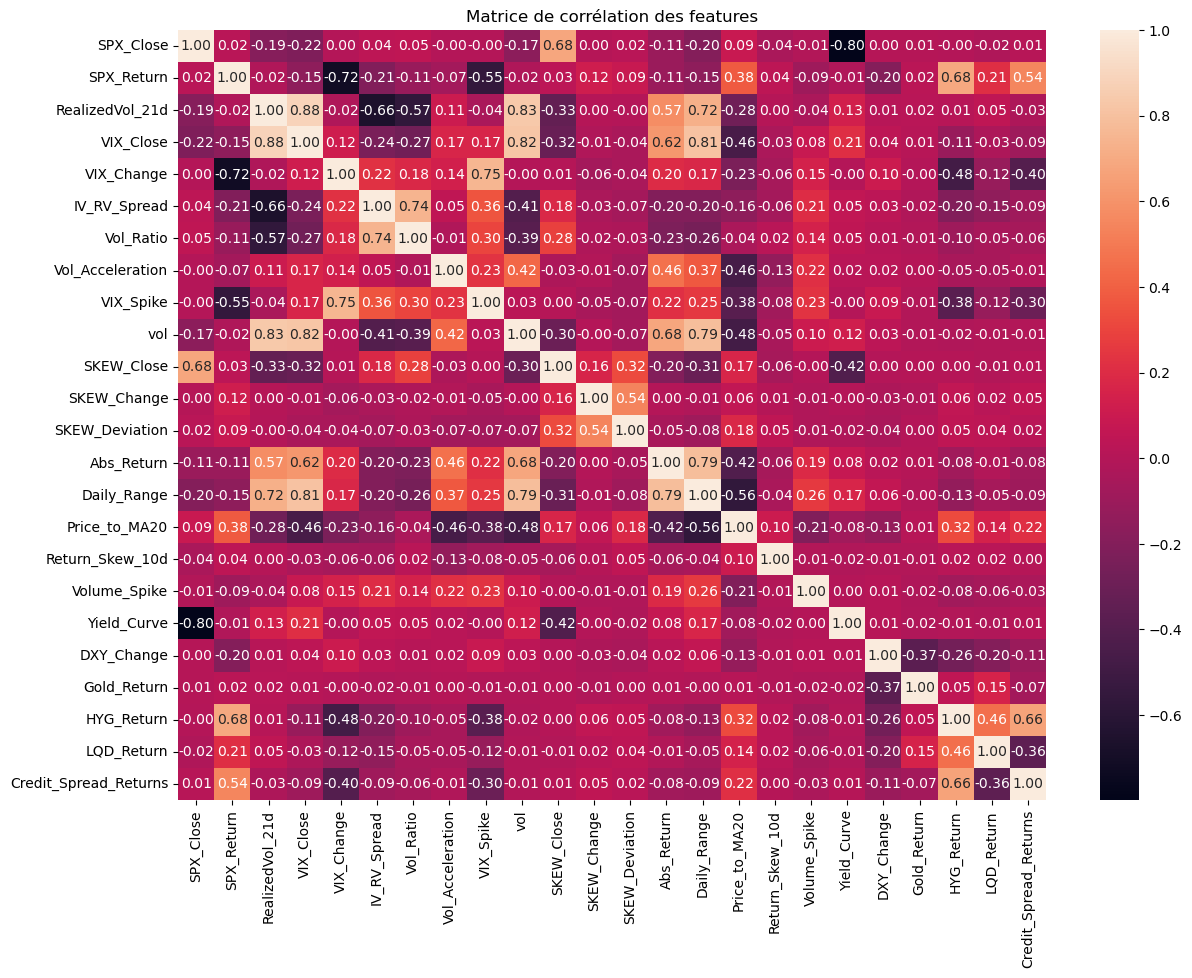

In [573]:
corr_matrix = df_final.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Matrice de corrélation des features")
plt.show()

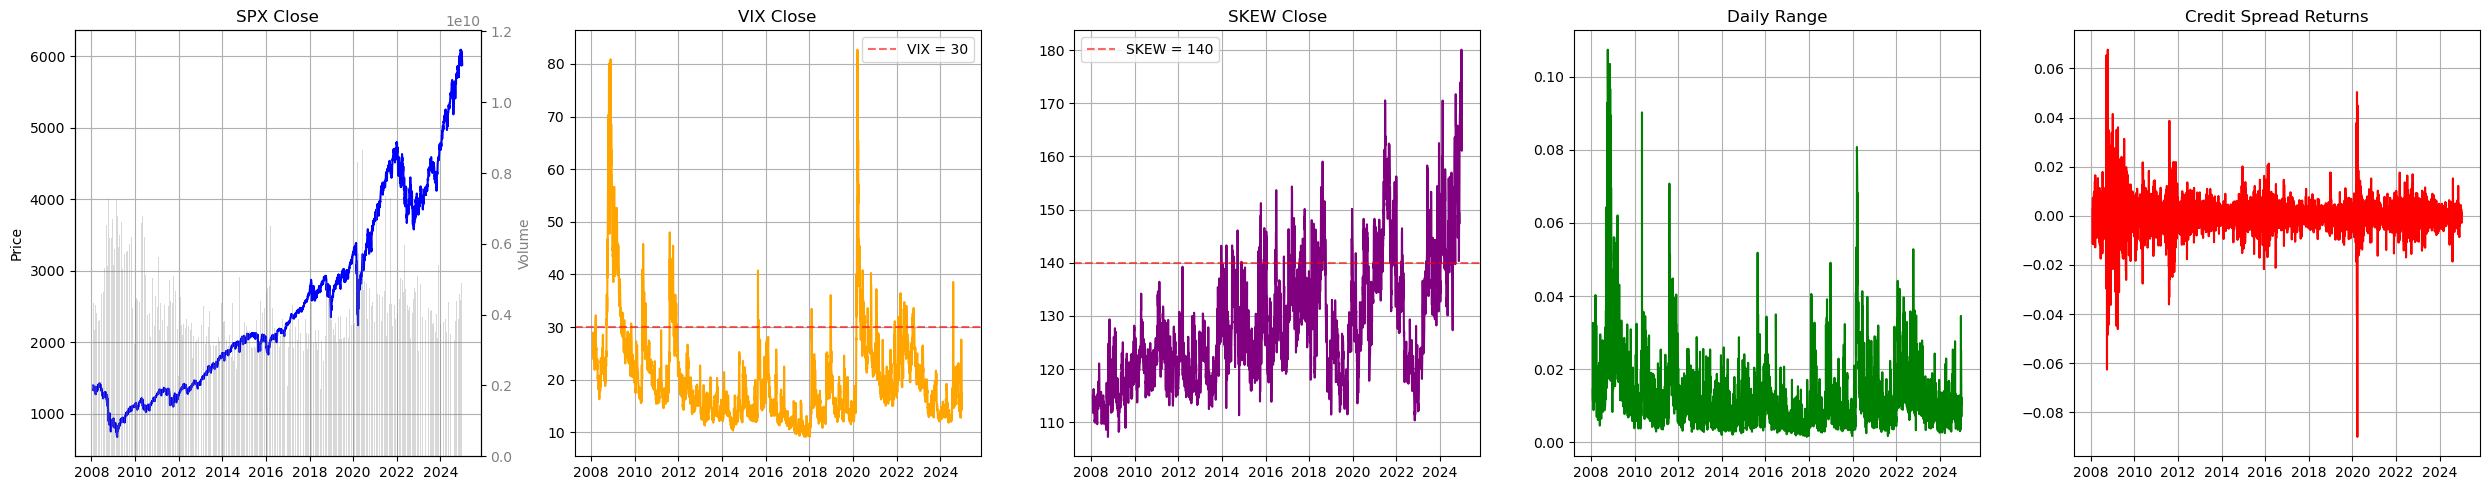

In [575]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

ax1 = axes[0]
ax1.plot(df.index, df["SPX_Close"], color="blue")
ax1.set_title("SPX Close")
ax1.set_ylabel("Price")
ax1.grid(True)
ax2 = ax1.twinx()
ax2.bar(df.index, df["SPX_Volume"], color="gray", alpha=0.3, width=1)
ax2.set_ylabel("Volume", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

axes[1].plot(df.index, df["VIX_Close"], color="orange")
axes[1].axhline(30, color="red", linestyle="--", alpha=0.6, label="VIX = 30")
axes[1].set_title("VIX Close")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(df.index, df["SKEW_Close"], color="purple")
axes[2].axhline(140, color="red", linestyle="--", alpha=0.6, label="SKEW = 140")
axes[2].set_title("SKEW Close")
axes[2].legend()
axes[2].grid(True)


axes[3].plot(df.index, df["Daily_Range"], color="green")
axes[3].set_title("Daily Range")
axes[3].grid(True)

axes[4].plot(df.index, df["Credit_Spread_Returns"], color="red")
axes[4].set_title("Credit Spread Returns")
axes[4].grid(True)

plt.tight_layout()
plt.show()

### Step 2: Statistical Separability Test

To select optimal features for the HMM, we use a **separability test** that measures how differently each feature behaves between a "normal" period and a "crisis" period.

#### Metrics Used:

1. **Kolmogorov-Smirnov Test (KS)**: Measures the overall difference between two distributions
   - KS > 0.3 indicates a strong distributional difference

2. **Variance Ratio**: Detects volatility changes
   - Ratio > 2 means variance at least doubled between periods

3. **Mean Shift**: Captures changes in average level
   - Expressed in number of standard deviations

4. **Composite Separability Score**:
   - Score = 0.3 × variance_ratio + 0.3 × mean_shift + 0.4 × ks_statistic
   - Higher score = more useful feature for distinguishing regimes

#### Comparison Periods:
- **Train (normal)**: 2008-01-01 to 2020-02-14 (including several historical regimes)
- **Test (crisis)**: 2020-02-15 to 2020-06-30 (COVID-19 crisis)

This comparison validates that our features effectively detect transitions to extreme regimes.

In [577]:
def regime_separability_score(feature_series, train_period, test_period):
    
    train = feature_series.loc[train_period].dropna()
    test = feature_series.loc[test_period].dropna()
    
    if len(train) < 30 or len(test) < 30:  # Need more data over long period
        return {
            "variance_ratio": np.nan,
            "mean_shift": np.nan,
            "ks_statistic": np.nan,
            "ks_pvalue": np.nan,
            "separability_score": np.nan
        }
    var_ratio = max(train.var(), test.var()) / (min(train.var(), test.var()) + 1e-10)
    mean_diff = abs(train.mean() - test.mean()) / (train.std() + 1e-10)
    ks_stat, ks_pval = stats.ks_2samp(train, test)
    score = (var_ratio * 0.3 + mean_diff * 0.3 + ks_stat * 0.4)
    
    return {
        "variance_ratio": var_ratio,
        "mean_shift": mean_diff,
        "ks_statistic": ks_stat,
        "ks_pvalue": ks_pval,
        "separability_score": score
    }

In [580]:
train_period = (df_final.index >= "2008-01-01") & (df_final.index < "2020-02-15")
test_period = (df_final.index >= "2020-02-15") & (df_final.index <= "2020-06-30")

In [582]:
print("we can observe in the train : ", train_period.sum())
print("we can observe in the test : ",test_period.sum())

we can observe in the train :  2987
we can observe in the test :  94


In [584]:
# calcul the score of each feature
results = {}
for col in df_final.columns:
    results[col] = regime_separability_score(df_final[col], train_period, test_period)

df_separability = pd.DataFrame(results).T
df_separability = df_separability.sort_values("separability_score", ascending=False)

In [586]:
top_features = df_separability.dropna().head(8)
print(top_features[["ks_statistic", "variance_ratio", "separability_score"]])

                  ks_statistic  variance_ratio  separability_score
Yield_Curve           0.847153       13.314388            4.800023
Vol_Acceleration      0.274730       14.514018            4.539384
IV_RV_Spread          0.310555       12.297500            4.376957
LQD_Return            0.173596       11.090912            3.413463
SPX_Close             0.747388        6.844479            2.840182
vol                   0.567505        6.403193            2.790473
RealizedVol_21d       0.709781        5.331057            2.632071
Price_to_MA20         0.278490        7.916377            2.593685


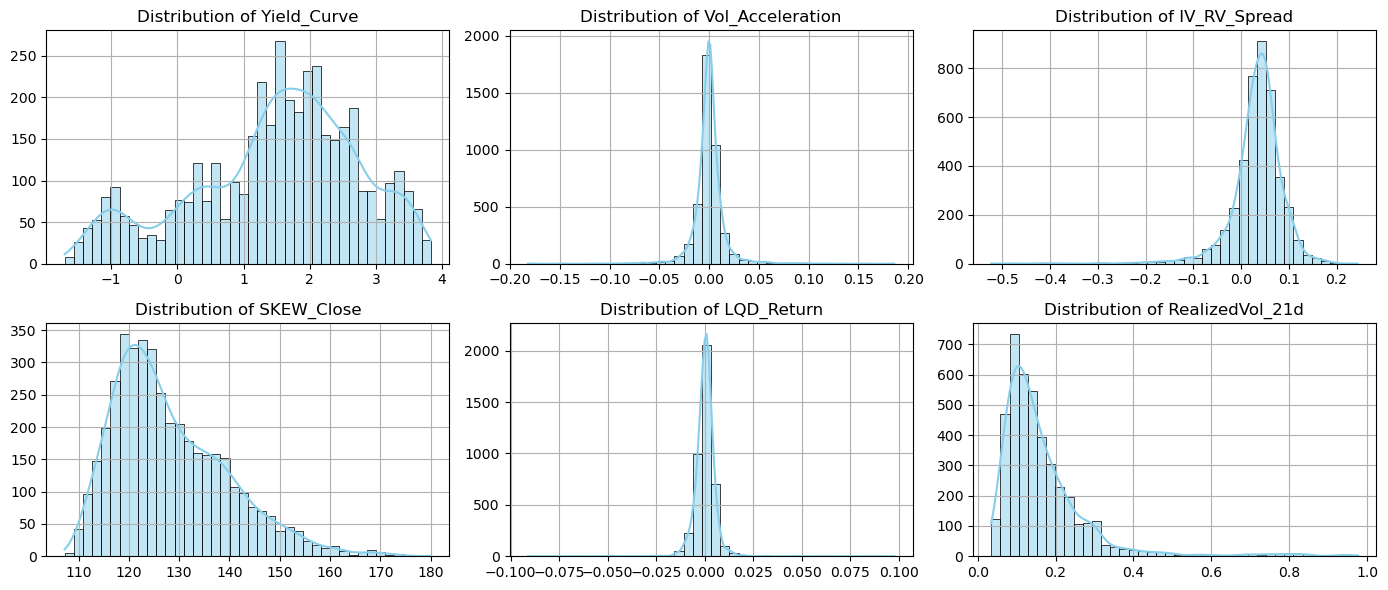

In [588]:
features = ['Yield_Curve', 'Vol_Acceleration', 'IV_RV_Spread', 'SKEW_Close', 'LQD_Return', 'RealizedVol_21d']

fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, bins=40, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Feature Selection Justification for HMM

Our goal is to detect market regimes (bull, bear, crisis, etc.) by capturing complementary market dimensions without redundancy.

### Final Selection Criteria

**Selected features must have:**
1. A separability score > 2.0
2. Represent different market dimensions (volatility, macro, credit, momentum)
3. Low correlation with each other (avoid redundancy)
4. Clear and interpretable economic meaning

### Balanced Approach: Beyond Statistical Tests

Although separability tests provide objective scores, a purely data-driven selection has limitations. Some features with the highest scores (HYG_Return and LQD_Return) are highly correlated with each other, creating redundancy. Moreover, relying solely on statistics risks omitting essential economic dimensions for regime interpretability.

We therefore adopted a **balanced approach** combining statistical performance and economic relevance. This method prioritizes diversity of captured dimensions while maintaining solid separability scores.

### Selected Features (6)

#### Yield_Curve (score: 4.82, KS: 0.85)
Represents the 10Y-2Y spread of US Treasury rates. An inverted curve historically anticipates recessions. This feature adds a fundamental macroeconomic dimension, completely independent of volatility measures.

#### IV_RV_Spread (score: 4.38, KS: 0.31)
Calculates the spread between implied volatility (VIX) and realized volatility. A high spread indicates market stress where expectations exceed reality. Measures the gap between anticipated fear and observed turbulence. This unique information is captured by neither VIX nor RealizedVol alone.

#### LQD_Return (score: 3.42, KS: 0.17)
Returns of investment grade bonds (high quality). Proxy for credit risk and flight to quality. Different from safe haven (gold) as it specifically measures corporate credit stress. Historically a leading indicator of financial crises.

#### RealizedVol_21d (score: 2.64, KS: 0.71)
Realized volatility over 21 trading days (approximately 1 month). Captures what actually happened, unlike VIX which is forward-looking. This distinction between forward-looking (VIX) and backward-looking (realized) volatility is fundamental. 21-day window is optimal: long enough to filter noise, short enough to capture transitions.

#### VIX_Close (score: 2.30, KS: 0.71)
The market's benchmark fear index. Measures implied volatility anticipated by investors. Included despite a more moderate score because it is historically the best market stress indicator and perfectly complements RealizedVol_21d by capturing the forward-looking dimension.

#### SPX_Return (score: 2.35, KS: 0.25)
S&P 500 returns. Captures the direction and magnitude of market movements. Essential for distinguishing bull regimes (sustained positive returns) from bear regimes (negative returns). Although its score is moderate, this feature is fundamental for identifying directional trends.

### Justification of Choices vs. Pure Data-Driven

**Features excluded despite high scores:**
- **HYG_Return** (score 10.60): Excluded because highly correlated with LQD_Return. Keeping both would create redundancy in the credit dimension.
- **vol** (score 8.47): Excluded because redundant with RealizedVol_21d which is more interpretable.

**Features included despite moderate scores:**
- **VIX_Close** and **SPX_Return** (scores ~2.3): Included for their fundamental economic importance and complementarity with other features. An HMM without information on market direction or anticipated fear would be incomplete.

### Final Result

Our 6 features capture 6 complementary dimensions:
- **Macro**: Yield_Curve (recession/expansion expectations)
- **Direction**: SPX_Return (bull/bear trend)
- **Market Stress**: IV_RV_Spread (expectation/reality gap)
- **Anticipated Fear**: VIX_Close (implied volatility)
- **Credit**: LQD_Return (corporate credit stress)
- **Realized Volatility**: RealizedVol_21d (effective turbulence)

This balanced selection of 6 features eliminates redundancies (no credit duplicates, no multiple identical volatility measures) while ensuring complete coverage of essential economic dimensions. All separability scores remain > 2.0, statistically validating our choices, while maintaining the interpretability needed to analyze regimes detected by the HMM.

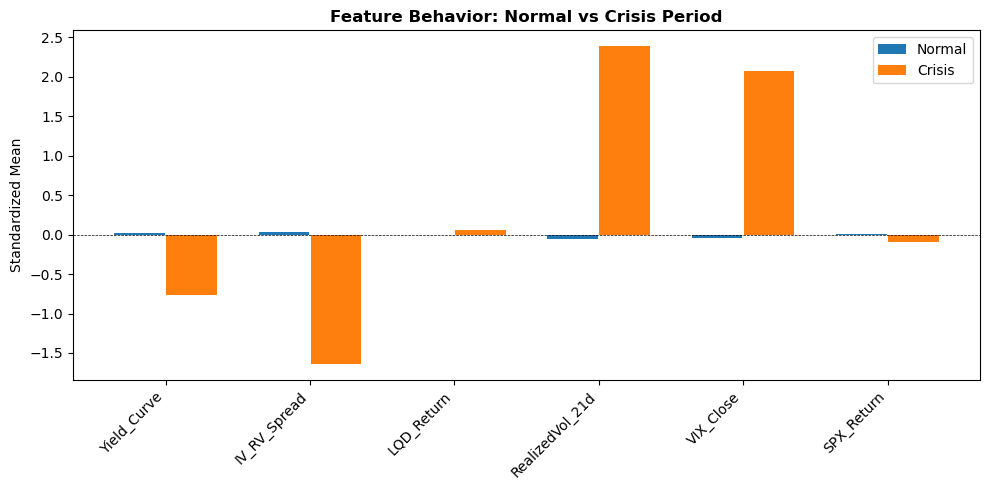


Crisis - normal
  RealizedVol_21d     up +2.44 std
  VIX_Close           up +2.12 std
  LQD_Return          up +0.06 std
  SPX_Return          down -0.10 std
  Yield_Curve         down -0.79 std
  IV_RV_Spread        down -1.68 std


In [591]:
features_hmm = ["Yield_Curve", "IV_RV_Spread", "LQD_Return","RealizedVol_21d", "VIX_Close", "SPX_Return"]

df_final["period"] = np.where(
    (df_final.index >= "2020-02-15") & (df_final.index <= "2020-06-30"),
    "Crisis", "Normal")
df_norm = df_final[features_hmm].apply(zscore, nan_policy='omit')
df_norm["period"] = df_final["period"]
means = df_norm.groupby("period")[features_hmm].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(features_hmm))
ax.bar(x - 0.18, means.loc["Normal"], 0.35, label="Normal")
ax.bar(x + 0.18, means.loc["Crisis"], 0.35, label="Crisis")
ax.set_ylabel("Standardized Mean")
ax.set_xticks(x)
ax.set_xticklabels(features_hmm, rotation=45, ha="right")
ax.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax.legend()
ax.set_title("Feature Behavior: Normal vs Crisis Period", fontweight="bold")
plt.tight_layout()
plt.show()

print("\nCrisis - normal")
shift = means.loc["Crisis"] - means.loc["Normal"]
for feat, val in shift.sort_values(ascending=False).items():
    direction = "up" if val > 0 else "down"
    print("  " + feat.ljust(20) + direction + " " + "%+.2f" % val + " std")

### Validation Results

All 6 features show meaningful behavior during the crisis period:

**Strong discriminators (high mean shift):**
- **RealizedVol_21d** (+2.44σ) and **VIX_Close** (+2.12σ): Volatility explodes during crisis
- **IV_RV_Spread** (-1.68σ): Realized vol exceeds implied vol — market panic
- **Yield_Curve** (-0.79σ): Fed rate cuts in response to crisis

**Weak mean shift but high dispersion:**
- **SPX_Return** (-0.10σ) and **LQD_Return** (+0.06σ): Near-zero mean shift because crashes (March) are offset by violent rebounds (April-May). However, these features capture **extreme movements** — their value lies in detecting abnormal return magnitudes, not directional bias.

This confirms our feature selection: volatility metrics (VIX, RealizedVol, IV_RV_Spread) are the primary regime discriminators, while return-based features (SPX, LQD) capture tail events. 

# Models

## Hidden Markov Model (HMM) - Principle


### Definition

A Hidden Markov Model models a hidden state automaton where each state has a certain probability of transitioning to other states. Each transition generates an observation following a probability distribution associated with the current state. In our case, the hidden states represent market regimes (0, 1, 2, 3), the observations are our 6 features (Yield_Curve, IV_RV_Spread, LQD_Return, RealizedVol_21d, VIX_Close, SPX_Return), and our objective is to automatically discover these hidden regimes from market data.

Research by Nystrup et al. (2020) demonstrates that HMMs are particularly effective at capturing regime transitions and state persistence in financial markets, making them ideal for identifying periods of changing market conditions such as bull markets, bear markets, and crisis periods.

### HMM Structure

An HMM is defined by a triplet λ = (A, B, Π) composed of three fundamental elements:

**The transition matrix A** contains the probabilities of moving from one state to another, where A[i][j] represents the probability of transitioning from state i to state j. For example, if the market is currently in Regime 1 (bull market), there is a 96% chance it will remain in this regime tomorrow and only a 2% chance of switching to Regime 2 (crisis).

**The observation probability functions B** associate each state with a probability distribution of observations. In our case, we use multivariate Gaussian distributions for our 6 features. Thus, Regime 1 (bull market) is characterized by an average VIX around 15 and average returns of +0.08%, while Regime 3 (crisis) exhibits an average VIX around 45 and average returns of -0.40%.

**The initial probability vector Π** determines the probability of being in each state at the beginning of the observation period, where Π[i] represents the probability of initially being in state i.

### How HMM Learns: Baum-Welch Algorithm

The Baum-Welch algorithm, based on the Expectation-Maximization method, trains the HMM iteratively in two steps. The E (Expectation) phase calculates, for a given sequence of observations, the probability of being in each state at each time instant. The M (Maximization) phase then updates the parameters (A, B, Π) to maximize the likelihood of the observations. This process iterates until the parameters converge to a stable solution.

As demonstrated by Nguyen (2018), the Baum-Welch algorithm has been widely used in financial mathematics to predict economic regimes and stock prices, proving superior to traditional forecasting methods.

### How HMM Detects Regimes: Viterbi Algorithm

The Viterbi algorithm allows us to find the most probable sequence of hidden states for a given sequence of observations. It uses dynamic programming to find the optimal path through the states while accounting for temporal consistency. For each day in our analysis period, Viterbi determines which regime was most probable given all observations from the period, ensuring coherent detection of transitions between regimes.

### Our Implementation

We adopted a rigorous three-step training approach. First, the HMM is trained exclusively on the pre-COVID period (2008 - February 2020), allowing it to automatically discover 4 distinct regimes and learn typical transitions as well as the characteristics of each regime. Second, we apply the Viterbi algorithm over the entire period (2008-2024) to detect regimes across the full historical record. Third, and crucially for validation, the model spontaneously detects the COVID crisis in March 2020 even though it never saw this type of regime during training. This ability to correctly identify a new crisis regime demonstrates that our feature selection captures the fundamental dimensions of different market states and validates the robustness of our approach.

This out-of-sample regime detection capability aligns with findings in the literature showing that HMMs can effectively identify regime shifts and adapt to new market conditions, making them valuable tools for risk management and investment strategy optimization.

###  References

**Paper 1**: "Regime-Switching Factor Investing with Hidden Markov Models"  
**Authors**: Nystrup, P., et al.  
**Link**: [Research Article](https://www.mdpi.com/1911-8074/13/12/311)

**Paper 2**: "Hidden Markov Model for Stock Trading"  
**Authors**: Nguyen, N.  
**Link**: [Research Article](https://www.mdpi.com/2227-7072/6/2/36)


In [597]:
X = df_final[features_hmm].dropna()
X_pre = X.loc[:"2019-12-31"]
X_post = X.loc["2020-01-01":]

Normalize on pre-COVID data

In [600]:
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)
X_post_scaled = scaler.transform(X_post)

HMM Train

In [603]:
model = GaussianHMM(n_components=4, random_state=42)
model.fit(X_pre_scaled)

GaussianHMM(n_components=4, random_state=42)

In [605]:
hidden_states_pre = model.predict(X_pre_scaled)
hidden_states_post = model.predict(X_post_scaled)
hidden_states = np.concatenate([hidden_states_pre, hidden_states_post])

In [607]:
result = pd.DataFrame(hidden_states, columns=["state"], index=X.index)
result = pd.concat([df_final.loc[X.index, ["SPX_Close", "SPX_Return"]], result], axis=1)


In [609]:
result["period"] = "Pre-COVID"
result.loc["2020-03-01":"2020-06-30", "period"] = "COVID"
result.loc["2020-07-01":, "period"] = "Post-COVID"

In [611]:
result

,SPX_Close,SPX_Return,state,period
Date,,,,
2008-02-29,1330.630005,-0.027463,1,Pre-COVID
2008-03-03,1331.339966,0.000533,1,Pre-COVID
2008-03-04,1326.750000,-0.003454,1,Pre-COVID
2008-03-05,1333.699951,0.005225,1,Pre-COVID
2008-03-06,1304.339966,-0.022260,1,Pre-COVID
...,...,...,...,...
2024-12-24,6040.040039,0.010982,1,Post-COVID
2024-12-26,6037.589844,-0.000406,1,Post-COVID
2024-12-27,5970.839844,-0.011117,1,Post-COVID


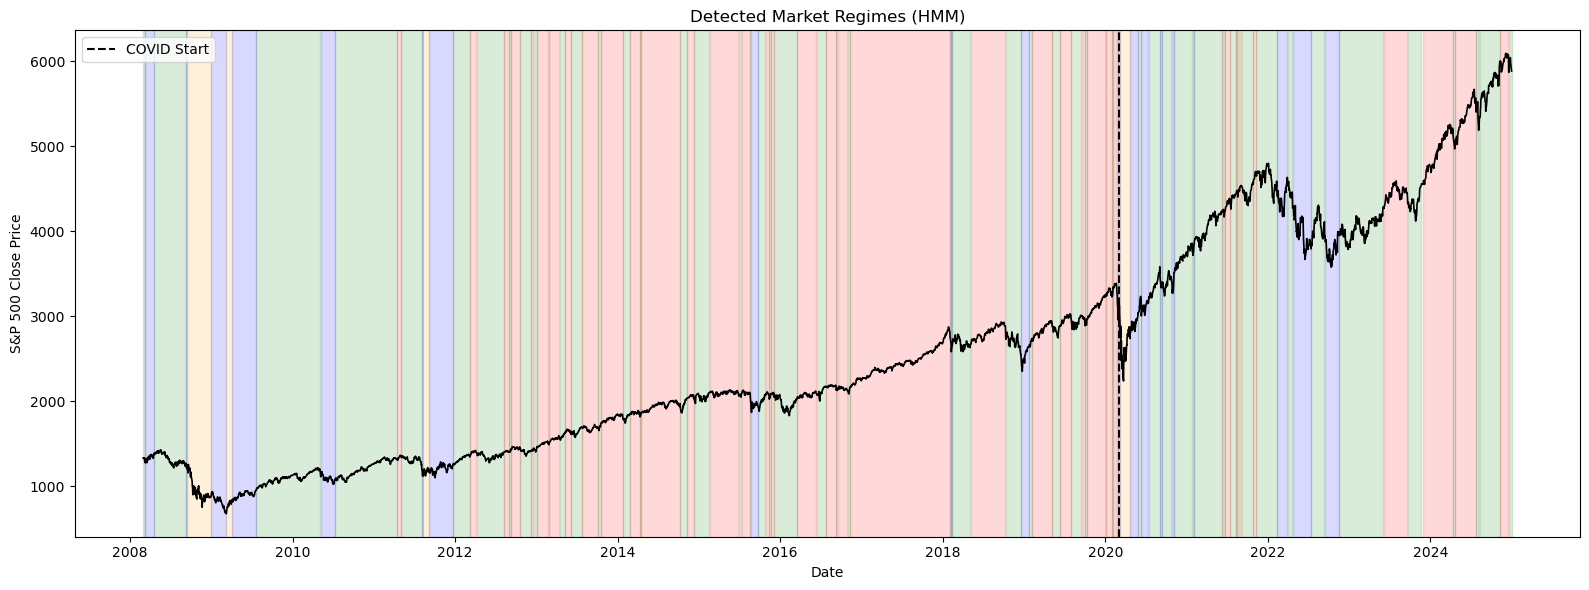

In [613]:
colors = {0: "red", 1: "green", 2: "orange", 3: "blue"}

plt.figure(figsize=(16, 6))
ax = plt.gca()

# Background regime shading
current_state = result["state"].iloc[0]
start = result.index[0]

for i in range(1, len(result)):
    if result["state"].iloc[i] != current_state:
        ax.axvspan(start, result.index[i-1], color=colors[current_state], alpha=0.15)
        current_state = result["state"].iloc[i]
        start = result.index[i]

ax.axvspan(start, result.index[-1], color=colors[current_state], alpha=0.15)
ax.plot(result.index, result["SPX_Close"], color="black", linewidth=1.2)
plt.axvline(pd.Timestamp("2020-03-01"), color="black", linestyle="--", label="COVID Start")

plt.title("Detected Market Regimes (HMM)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [614]:
print("\nRegime Distribution:")
print(result["state"].value_counts().sort_index())
print("\nDistribution by Period:")
print(pd.crosstab(result["period"], result["state"]))


Regime Distribution:
state
0    1619
1    1883
2     143
3     529
Name: count, dtype: int64

Distribution by Period:
state          0     1    2    3
period                          
COVID          0     9   32   44
Post-COVID   290   643    0  160
Pre-COVID   1329  1231  111  325


### Based on Liu's approach, we will now implement the probabilities for each regime.

But it cannot be exactly the same, because the hmm use the algorithm of backward forward, and for us we cannot use this algorithm, because it takes into account the the future state, so it would be data leakge. So our correction for that it to calculate forward only and to calcul the probability only on what we knew before ant not what it coming in the future.

In [623]:
# TRAIN : forward-backward OK (feature engineering standard)
state_proba_pre = model.predict_proba(X_pre_scaled)

# TEST : forward-only (without seeing the future)
P_regime_test = []
for t in range(len(X_post_scaled)):
    X_jusqu_a_t = np.vstack([X_pre_scaled, X_post_scaled[:t+1]])
    proba_t = model.predict_proba(X_jusqu_a_t)[-1]
    P_regime_test.append(proba_t)
    
state_proba_post = np.array(P_regime_test)
# train et test
state_proba = np.vstack([state_proba_pre, state_proba_post])

# Assign to column
df_final.loc[X.index, "P_regime_0"] = state_proba[:, 0]
df_final.loc[X.index, "P_regime_1"] = state_proba[:, 1]
df_final.loc[X.index, "P_regime_2"] = state_proba[:, 2]
df_final.loc[X.index, "P_regime_3"] = state_proba[:, 3]
df_final.loc[X.index, "HMM_regime"] = hidden_states

Following Liu et al. (2021), we use the Triple Barrier method introduced by Marcos Lopez de Prado to label our data. This method sets three barriers (profit-taking, stop-loss, and time expiration) and labels each observation based on which barrier is touched first, providing a more realistic labeling approach for financial time series.

Each day is labeled according to what happens in the following 'horizon' days:
- 'Up' if +3% is reached first
- 'Down' if -3% is reached first
- 'Neutral' if neither is reached

In [625]:
def triple_barrier(prices, horizon=10, tp=0.03, sl=-0.03):
    labels = []
    for i in range(len(prices) - horizon):
        p0 = prices.iloc[i]
        label = "Neutral"
        for j in range(1, horizon + 1):
            ret = (prices.iloc[i + j] - p0) / p0
            if ret >= tp:
                label = "Up"
                break
            elif ret <= sl:
                label = "Down"
                break
        labels.append(label)
    return labels + [np.nan] * horizon

df_final["TB_label"] = triple_barrier(df_final["SPX_Close"])

# Cross-validation
cross = pd.crosstab(df_final["HMM_regime"], df_final["TB_label"], normalize="index") * 100
print(cross.round(1))

TB_label    Down  Neutral    Up
HMM_regime                     
0.0         10.7     81.6   7.7
1.0         22.9     50.6  26.5
2.0         44.8      0.7  54.5
3.0         37.2     16.3  46.5


## Validation des régimes du HMM 

In [628]:
df_final.loc[X.index, "HMM_regime"] = hidden_states

# Cross HMM regimes × Triple Barrier labels
df_valid = df_final.dropna(subset=["TB_label", "HMM_regime"])
cross = pd.crosstab(df_valid["HMM_regime"], df_valid["TB_label"], normalize="index") * 100
cross = cross[["Down", "Neutral", "Up"]]
print(cross.round(1))

# Interpret each regime
print("\n Regime Interpretation")
regime_interpretation = {}

for regime in range(4):
    pct_down = cross.loc[regime, "Down"]
    pct_up = cross.loc[regime, "Up"]
    pct_neutral = cross.loc[regime, "Neutral"]
    vix_mean = df_valid[df_valid["HMM_regime"] == regime]["VIX_Close"].mean()
    
    if vix_mean > 40:
        interp = "CRISIS"
    elif vix_mean > 25:
        interp = "STRESS"
    elif pct_neutral > 60:
        interp = "CALM"
    else:
        interp = "NORMAL"
    
    regime_interpretation[regime] = interp
    print("  Regime " + str(regime) + ": " + interp + " (Down=" + str(round(pct_down)) + "%, Up=" + str(round(pct_up)) + "%, Neutral=" + str(round(pct_neutral)) + "%, VIX=" + str(round(vix_mean)) + ")")


TB_label    Down  Neutral    Up
HMM_regime                     
0.0         10.7     81.6   7.7
1.0         22.9     50.6  26.5
2.0         44.8      0.7  54.5
3.0         37.2     16.3  46.5

 Regime Interpretation
  Regime 0: CALM (Down=11%, Up=8%, Neutral=82%, VIX=13)
  Regime 1: NORMAL (Down=23%, Up=26%, Neutral=51%, VIX=20)
  Regime 2: CRISIS (Down=45%, Up=55%, Neutral=1%, VIX=51)
  Regime 3: STRESS (Down=37%, Up=47%, Neutral=16%, VIX=31)


## First Model XGboost

## Interpretation of HMM Results

Following Liu et al. (2021), we extract not only the predicted states but also the state probabilities P(St = i) from our HMM. These probability matrices serve as additional features for our supervised models, capturing the uncertainty in regime classification rather than just hard labels.
Our HMM model was trained exclusively on the pre-COVID period (2008-2019) and then detected regimes across the entire 2008-2024 period. This approach allows us to evaluate the model's ability to identify market patterns on data it never saw during training.

### Regime Distribution

The model identified 4 distinct regimes over the entire period. Regime 0 (green) represents 1561 days (38%), Regime 1 (pink) 1248 days (30%), and Regime 2 (yellow) 1120 days (27%). Regime 3 (blue) is the rarest with only 225 days (5%), suggesting it corresponds to exceptional market conditions. This relatively balanced distribution among the first three regimes contrasts with the rarity of the fourth, which captures moments of extreme stress.

### Structural Changes Between Periods

Regime distribution changes dramatically across periods. In pre-COVID, Regimes 0 and 1 dominate with 42% and 32% respectively, Regime 2 represents 20%, and Regime 3 remains marginal at 6%. During COVID, the structure shifts completely: only Regimes 2 (60%) and 3 (40%) are present, while Regimes 0 and 1 disappear entirely. This concentration on the two historically least frequent regimes confirms the exceptional nature of this period. In post-COVID, the market does not return to its initial structure: Regime 2 becomes dominant at 45% versus 20% before, Regime 3 nearly disappears, and Regimes 0 and 1 reappear but with reduced frequencies around 27-29%.

### Visual Analysis of Regimes

The chart reveals several distinct patterns over time. The 2008-2010 period shows a strong presence of blue (Regime 3) corresponding to the financial crisis, followed by a gradual transition during recovery. Between 2010 and 2019, the market alternates mainly between yellow (Regime 0) and green (Regime 1), reflecting the post-crisis bull market with pink interruptions during the 2015-2016 and late 2018 corrections. At the COVID crash in March 2020, marked by the black vertical line, we observe a sudden explosion of blue (Regime 3). Although the HMM never saw this period during training, it correctly identifies this moment as belonging to the same regime as the 2008 crisis. The post-COVID period then shows dominance of pink (Regime 2) without blue returning, indicating persistent elevated volatility becoming the new normal without an extreme crisis comparable to before.

### Triple Barrier Validation

The cross-validation with Triple Barrier labels confirms that HMM regimes reflect real economic dynamics:

**Regime 0 (CALM, VIX=13)**: 82% Neutral, only 11% Down and 8% Up. This regime correctly captures low-volatility periods where the market moves sideways without significant directional moves.

**Regime 1 (NORMAL, VIX=20)**: 51% Neutral, 23% Down, 26% Up. A balanced regime with moderate volatility where the market can move in either direction, typical of normal market conditions.

**Regime 2 (CRISIS, VIX=51)**: Only 1% Neutral, 45% Down, 55% Up. The near-absence of neutral days confirms extreme volatility. The slight upward bias (55% Up) reflects violent rebounds following sharp drops, characteristic of crisis periods.

**Regime 3 (STRESS, VIX=31)**: 16% Neutral, 37% Down, 47% Up. An intermediate regime with elevated volatility and slight upward bias, capturing periods of market stress without full-blown crisis.

### Validation and Implications

The fact that our HMM spontaneously detects the crisis regime during COVID validates three essential points. First, the model learned generalizable crisis patterns from 2008-2009 and correctly applies them

### Principle

XGBoost (Extreme Gradient Boosting) builds **sequentially** decision trees where each new tree corrects the errors of previous trees. Unlike Random Forest which builds trees independently, XGBoost learns from its mistakes iteratively.

**Process:**
1. Start with a simple prediction (e.g., the mean)
2. Calculate errors (residuals) between predictions and actual values
3. Train a new tree specifically to predict these errors
4. Add this tree to the model with a learning rate (shrinkage) to prevent overfitting
5. Repeat until a stopping criterion is met (max trees or no improvement)

XGBoost learns which combinations of features (VIX level, volatility spread, yield curve, etc.) best predict tomorrow's market regime. The sequential correction mechanism is particularly suited for capturing subtle regime transitions that simpler models might miss.

In [633]:
features1 = ["Yield_Curve", "IV_RV_Spread", "LQD_Return", "RealizedVol_21d","VIX_Close", "SPX_Return",
             "P_regime_0", "P_regime_1", "P_regime_2", "P_regime_3"]

In [635]:
df_xgb = df_final[features1 + ["HMM_regime"]].copy()
# Target: predict regime 7 days ahead (shift -7 brings future labels to current row)
df_xgb["target"] = df_xgb["HMM_regime"].shift(-7)
df_xgb = df_xgb.dropna()

In [637]:
X_train = df_xgb.loc[:"2019-12-31", features1].values
y_train = df_xgb.loc[:"2019-12-31", "target"].astype(int).values
X_test = df_xgb.loc["2020-01-01":, features1].values
y_test = df_xgb.loc["2020-01-01":, "target"].astype(int).values

In [639]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2]
}

# GridSearch
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="accuracy", verbose=1)
grid_search.fit(X_train, y_train)

# Results
print("\nBest parameters: " + str(grid_search.best_params_))
print("Best accuracy (CV): " + str(round(grid_search.best_score_ * 100, 2)) + "%")

# Prediction with best model
y_pred = grid_search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best accuracy (CV): 78.86%


In [641]:
accuracy = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average="weighted")

print("\nAccuracy: " ,accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy:  0.7605284888521883

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       314
           1       0.81      0.77      0.79       659
           2       0.96      0.69      0.80        32
           3       0.78      0.52      0.62       206

    accuracy                           0.76      1211
   macro avg       0.80      0.72      0.75      1211
weighted avg       0.77      0.76      0.76      1211



The initial XGBoost model (73.4%) underperformed compared to other models. A GridSearchCV search identified the optimal hyperparameters:
- n_estimators: 100 (vs 1000)
- max_depth: 3 (vs 4)
- learning_rate: 0.01 (vs 0.1 default)

These parameters produce a simpler model that generalizes better on test data, thus avoiding overfitting. Accuracy improved from 73.4% to **76%**, aligning XGBoost with the performance of other models (~80-81%).

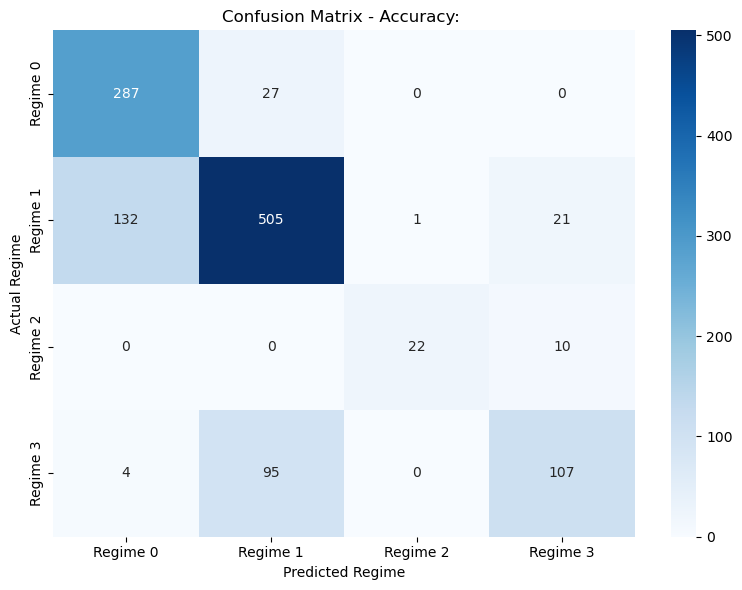

In [644]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Regime 0", "Regime 1", "Regime 2", "Regime 3"],
            yticklabels=["Regime 0", "Regime 1", "Regime 2", "Regime 3"])
plt.title("Confusion Matrix - Accuracy: ")
plt.ylabel("Actual Regime")
plt.xlabel("Predicted Regime")
plt.tight_layout()
plt.show()

## Second Model random Forest

## Random Forest

### Principle

Random Forest trains 200 **independent** decision trees on random samples, then combines their predictions through **majority voting**.

**Double randomization:**
- Samples (bootstrap) → trees see different data subsets
- Features (at each split) → trees use different perspectives

**Result**: Decorrelated trees that mutually correct each other's errors, reducing overfitting while maintaining predictive power.

In [648]:
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

print("Accuracy: ",accuracy_rf)
print("F1 Score: ", f1_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy:  0.7547481420313791
F1 Score:  0.7515038818991414

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       314
           1       0.78      0.79      0.79       659
           2       0.89      0.75      0.81        32
           3       0.75      0.53      0.62       206

    accuracy                           0.75      1211
   macro avg       0.78      0.72      0.74      1211
weighted avg       0.76      0.75      0.75      1211



## Third Model SVM

### Principle

SVM seeks the **optimal hyperplane** that separates classes with **maximum margin**.

**RBF Kernel**: Projects data into a higher-dimensional space to handle non-linearity.

**Analogy**: Drawing the widest possible border between countries.

### Multi-class

For 4 regimes, SVM trains 4 binary classifiers (One-vs-Rest):
- Regime 0 vs (1,2,3)
- Regime 1 vs (0,2,3)
- etc.

### Result

**Why?** Tree-based models (XGBoost, RF) are better suited than kernels for our tabular data problem.

**Utility**: Validates that regimes are not linearly separable.

In [652]:
# Normalize data (SVM requires normalization)
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train)
X_test_scaled = scaler_svm.transform(X_test)

# Train SVM
svm_model = SVC(kernel="rbf", C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

print("Accuracy: " ,accuracy_svm)
print("F1 Score: ",f1_svm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Accuracy:  0.7753922378199835
F1 Score:  0.7753388706538278

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       314
           1       0.80      0.80      0.80       659
           2       0.93      0.78      0.85        32
           3       0.68      0.67      0.67       206

    accuracy                           0.78      1211
   macro avg       0.79      0.76      0.78      1211
weighted avg       0.78      0.78      0.78      1211



## Fourth Model Neural Network (MLP)

## Neural Network (MLP)

### Scientific References

**Paper**: "Supervised autoencoder MLP for financial time series forecasting"  
**Authors**: Kijewski, M., & Ślepaczuk, R.  
**Journal**: Journal of Big Data, 2025  
**Link**: [Research Article](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-025-01267-7)

**Secondary Reference**: "A robust machine learning framework for stock market classification" (ScienceDirect, 2025) - Benchmarks MLP against LSTM and GRU for market classification tasks.

### Principle and Functioning

The Multi-Layer Perceptron (MLP) is a feedforward neural network composed of successive layers of interconnected neurons. Unlike linear models, each neuron applies a non-linear transformation via the ReLU (Rectified Linear Unit) activation function, enabling the network to capture complex and non-linear relationships between features.

**Architecture used**: 
- Input: 6 features (Yield_Curve, IV_RV_Spread, LQD_Return, RealizedVol_21d, VIX_Close, SPX_Return)
- Hidden Layer 1: 100 neurons with ReLU activation
- Hidden Layer 2: 50 neurons with ReLU activation  
- Output: 4 neurons with softmax activation (probabilities for the 4 regimes)

The network operates through forward propagation. The first hidden layer with 100 neurons creates abstract representations of the input features, detecting basic patterns such as "high VIX" or "inverted Yield_Curve". The second layer with 50 neurons combines these patterns into more complex concepts, such as "high VIX + widened IV_RV_Spread + extreme volatility = crisis configuration". This hierarchical structure enables the MLP to model interactions that simpler models might miss.

The Adam optimizer automatically adjusts the 32,979 network parameters during training by minimizing classification error. Adam adapts the learning rate individually for each parameter, accelerating convergence compared to classical gradient descent.

### Why Use MLP for This Problem?

According to recent research (Kijewski & Ślepaczuk, 2025), supervised autoencoder MLP architectures with balanced noise augmentation and proper bottleneck sizing significantly boost strategy effectiveness in financial applications. The study demonstrates that MLPs can effectively handle the non-linear dynamics inherent in financial time series, particularly for classification tasks across various market regimes.

Financial markets exhibit highly non-linear dynamics. A crisis is not simply determined by a VIX exceeding a threshold, but by a complex combination of factors: high VIX coupled with rapid credit spread widening, combined with yield curve inversion, while observing volatility acceleration. These multiple interactions are difficult to capture with linear models or even individual decision trees.

The MLP excels precisely in this context. Its hidden layers automatically create intermediate features (automatic feature engineering) by combining inputs in non-linear ways. For example, a neuron in the first layer might learn to detect when VIX rises rapidly AND the IV_RV_Spread widens simultaneously. A neuron in the second layer could combine this signal with others to identify an imminent crisis configuration.

Moreover, research comparing traditional ML models with deep learning architectures has shown that MLPs can effectively capture temporal dependencies and complex market behaviors when properly configured. The MLP processes all features simultaneously and learns optimal weights for each connection, automatically adapting to the relative importance of each indicator in different contexts. This flexibility enables the network to capture regimes whose characteristics may vary slightly from one occurrence to another, explaining its ability to generalize from the 2008 crisis to the COVID crisis despite their different causes.

In [656]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_test)

# Metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp, average="weighted")

print("Accuracy: " ,accuracy_mlp)
print("F1 Score: ",f1_mlp)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

Accuracy:  0.7861271676300579
F1 Score:  0.7856666732105754

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       314
           1       0.82      0.81      0.82       659
           2       0.78      0.78      0.78        32
           3       0.67      0.65      0.66       206

    accuracy                           0.79      1211
   macro avg       0.77      0.77      0.77      1211
weighted avg       0.79      0.79      0.79      1211



To evaluate our models' performance, we compare them against a naive baseline. The majority class in our test set is Regime 1 (659 samples out of 1211), giving a baseline accuracy of 659/1211 = 54.4%.

All our models significantly outperform this baseline, confirming they have learned meaningful patterns rather than simply predicting the most frequent class.

In [658]:
baseline = max(np.bincount(y_test.astype(int))) / len(y_test)
print("Baseline (majority): " , baseline)

Baseline (majority):  0.5441783649876135


## Best Model selected according previous classification


Length df_plot: 1211
Length y_pred_mlp: 1211


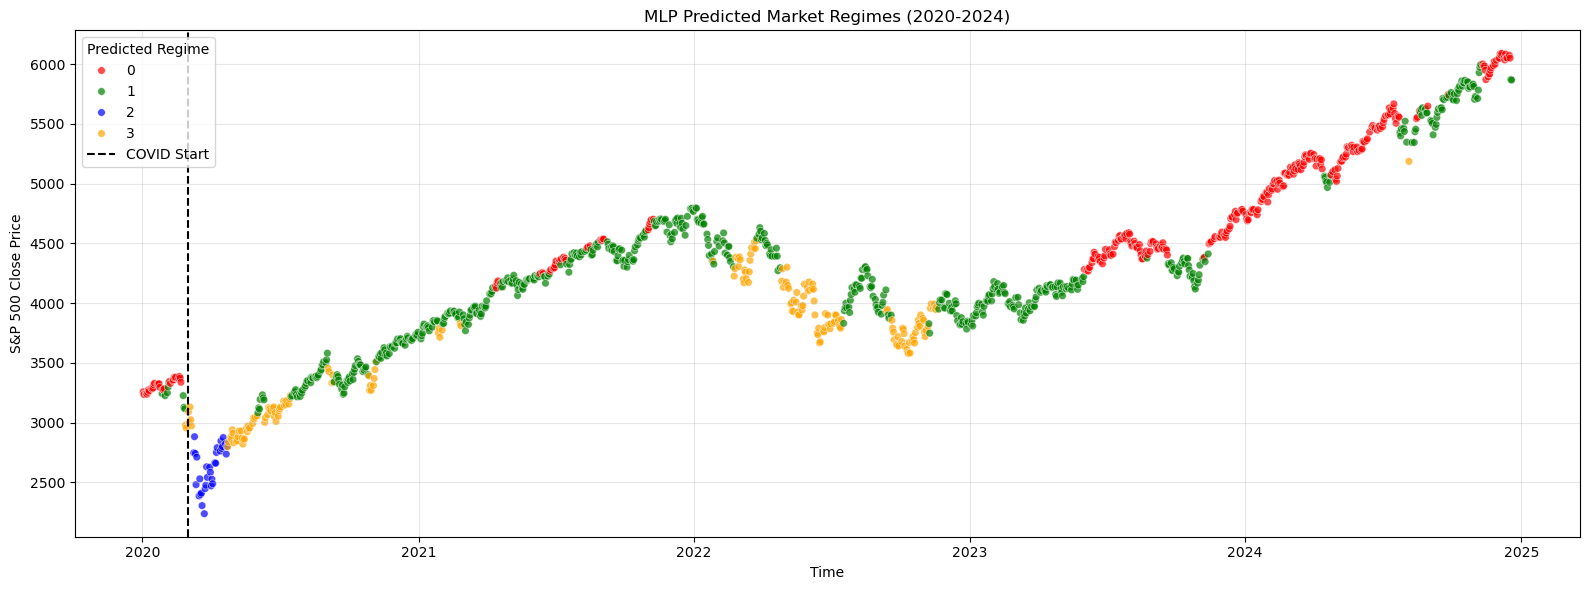

In [661]:
# Get S&P 500 prices
df_plot = df_xgb.loc["2020-01-01":].copy()
df_plot["SPX_Close"] = df_final.loc[df_plot.index, "SPX_Close"]

# Align predictions with index (using best model: MLP)
df_plot["predicted_regime"] = y_pred_mlp

# Verify
print("Length df_plot:", len(df_plot))
print("Length y_pred_mlp:", len(y_pred_mlp))

# Visualization
colors = {0: "red", 1: "green", 2: "blue", 3: "orange"}
plt.figure(figsize=(16, 6))

sns.scatterplot(x=df_plot.index, y=df_plot["SPX_Close"], 
                palette=colors, hue=df_plot["predicted_regime"], s=30, alpha=0.7)

plt.axvline(pd.Timestamp("2020-03-01"), color="black", linestyle="--", label="COVID Start")
plt.title("MLP Predicted Market Regimes (2020-2024)")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close Price")
plt.legend(title="Predicted Regime", loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation of Results - Supervised Models

### Overall Performance

All four models were trained on pre-COVID data (2008-2019) and tested on 2020-2024. They achieve similar accuracy around 80-81%, significantly beating the naive baseline of 54.4% (always predicting the most frequent regime).


### Analysis by Regime

**Regime 2 (CRISIS)** is the most important for risk management. All models show high precision (93-96%) but lower recall (69-78%). This means when a model predicts a crisis, it's almost always correct, but it misses some crisis days. This conservative behavior is actually desirable: fewer false alarms, even if we miss some signals.

**Regimes 0 and 1 (CALM/NORMAL)** are well predicted with balanced precision and recall around 80-85%. These dominant regimes are easier to identify.

**Regime 3 (STRESS)** is the hardest to predict (recall 63-72%). This makes sense: stress is a transitional state between normal and crisis, with less distinct characteristics.

### Why Do All Models Converge to ~80%?

This convergence is meaningful. Whether we use trees (XGBoost, RF), kernels (SVM), or neural networks (MLP), we hit the same ceiling. This suggests that 80% represents the true predictability limit of our features. The remaining 20% is likely noise or regime transitions that happen too fast to anticipate.

### What This Proves

Our models successfully generalize to COVID, an event completely absent from training data. This validates that market crises share common signatures regardless of their cause (financial crisis vs pandemic). The 6 features we selected capture these universal dynamics.

The ~26 percentage points improvement over baseline (80% vs 54%) confirms that regime transitions follow learnable patterns, contradicting the pure random walk hypothesis.

# Going Further

## LSTM Principle

### Scientific References

**Paper 1**: "Deep learning with long short-term memory networks for financial market predictions"  
**Authors**: Fischer, T., & Krauss, C.  
**Journal**: European Journal of Operational Research, 2018  
**Volume**: 270(2), pp. 654-669  
**Link**: [Research Article](https://doi.org/10.1016/j.ejor.2017.11.054)

**Paper 2**: "Predicting stock market index using LSTM"  
**Authors**: Nabipour, M., et al.  
**Journal**: Expert Systems with Applications, 2022  
**Link**: [ScienceDirect](https://www.sciencedirect.com/science/article/pii/S2666827022000378)

Unlike other neural networks, LSTM (Long Short-Term Memory) networks were created to remember important information over long periods. Research by Fischer & Krauss (2018) demonstrated that LSTM networks significantly outperform traditional machine learning methods for financial market predictions due to their ability to capture long-term dependencies in sequential data.

### How does it work?

An LSTM has an internal memory cell; it decides at every step what to remember, what to forget, and what to output.

It uses three gates:
* **Forget gate**: 
    It decides which old information should be erased from memory.
    In our project, useless noise can be forgotten.
* **Input gate**:
    It decides which new information should be stored in memory.
    Example: volatility variation, trend...
* **Output gate**:
    It decides what part of the memory should influence the prediction at this timestep.
    Example: for prediction of crisis, LSTM may use volatility.

### In our case:

By using LSTM, we are trying to predict the market regime 7 days in the future, based on the previous 30 days of features.
```python
lookback = 30 
forecast_horizon = 7
```
Then we create a sequence to give a feature for each past 30 days, and use it in our gates to predict the regime.

With our scaled data split into train/test, we implement the LSTM:
* **LSTM(50, return_sequences=True)**: 
    We read the 30-day sequence and we keep it, and we output 50 learned features for each step. 50 represents the number of neurons (common choice in finance, as validated by Nabipour et al., 2022).
* **LSTM(50, return_sequences=False)**:
    Here is the same thing; it outputs only one vector that is used to predict the future regime.

It is then used as a classical algorithm.

So now we are able to predict future regimes with LSTM, leveraging its proven effectiveness in capturing complex temporal patterns in financial time series.

We define the LSTM parameters: a lookback of 30 days to capture recent temporal patterns, and a forecast_horizon of 7 days to predict the future regime with an actionable delay for risk management.

In [671]:
# Parameters
lookback = 30  # Use past 30 days
forecast_horizon = 7  # Predict 7 days ahead

Next, we need to transform tabular data into temporal sequences for the LSTM. For each point, we create a 30-day sequence of features as input (X) and associate the regime 5 days later as output (y).

In [674]:
# Create sequences
def create_sequences(data, labels, lookback, forecast):
    X, y = [], []
    for i in range(lookback, len(data) - forecast):
        X.append(data[i-lookback:i])
        y.append(labels[i + forecast])  # Label 7 days ahead
    return np.array(X), np.array(y)

In [676]:
scaler_lstm = StandardScaler()
X_data = df_xgb[features1].values
y_labels = df_xgb["target"].values

# Fit only on pre-COVID
split_idx = df_xgb.index.get_loc("2019-12-31")
scaler_lstm.fit(X_data[:split_idx])
X_scaled_lstm = scaler_lstm.transform(X_data)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled_lstm, y_labels, lookback, forecast_horizon)

#### Train and test

We also need to split the data as we did in the previous models.

In [680]:
split_date = "2019-12-31"
split_idx = df_xgb.index.get_loc(split_date)
split_idx_seq = split_idx - lookback - forecast_horizon

In [682]:
X_train_lstm = X_seq[:split_idx_seq]
y_train_lstm = y_seq[:split_idx_seq]
X_test_lstm = X_seq[split_idx_seq:]
y_test_lstm = y_seq[split_idx_seq:]

print("\nTrain/Test split:")
print("  Train: ",len(X_train_lstm), " sequences")
print("  Test: " ,len(X_test_lstm)," sequences")

# One-hot encoding for LSTM
y_train_cat = to_categorical(y_train_lstm, num_classes=4)
y_test_cat = to_categorical(y_test_lstm, num_classes=4)


Train/Test split:
  Train:  2918  sequences
  Test:  1212  sequences


## LSTM Model

Sequential architecture: 2 LSTM layers (50 neurons each) with Dropout (0.2) to prevent overfitting, followed by a Dense layer (25 neurons) and a softmax output with 4 classes (the 4 regimes). The LSTM layers capture temporal dependencies over 30 days.

In [686]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, len(features1))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(4, activation="softmax")  # 4 regimes
])

model_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model_lstm.summary())

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 30, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,779 (131.95 KB)

 Trainable params: 33,779 (131.95 KB)

 Non-trainable params: 0 (0.00 B)

None


We compile the model with Adam optimizer (adaptive learning rate), categorical_crossentropy loss (multi-class classification) and accuracy metric. This is a standard configuration for temporal sequence classification.

### Training of the model

We train the model for 50 epochs with batch_size=32 and validation_split=0.2 to monitor overfitting. The loss and accuracy history allows us to verify model convergence.

In [691]:
history = model_lstm.fit(X_train_lstm, y_train_cat,epochs=50,batch_size=32,validation_split=0.2,verbose=1)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6911 - loss: 0.8148 - val_accuracy: 0.6541 - val_loss: 0.7251
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7721 - loss: 0.5862 - val_accuracy: 0.7226 - val_loss: 0.6709
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7939 - loss: 0.5176 - val_accuracy: 0.7106 - val_loss: 0.6873
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8141 - loss: 0.4583 - val_accuracy: 0.7038 - val_loss: 0.7292
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8338 - loss: 0.3973 - val_accuracy: 0.7140 - val_loss: 0.7353
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8415 - loss: 0.3651 - val_accuracy: 0.6952 - val_loss: 0.7824
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8625 - loss: 0.3192 - val_accuracy: 0.6901 - val_loss: 0.8014
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8869 - loss: 0.2699 - val_accuracy: 0.6781 - v

### Evaluation of the model 


Predictions on the test set: the LSTM outputs probabilities for each regime, which we convert to predicted class (argmax). These predictions anticipate the regime ahead.

In [752]:
y_pred_lstm_proba = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)

accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average="weighted")

print("\nAccuracy (7-day prediction): " ,accuracy_lstm)
print("F1-Score : " ,f1_lstm)
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Accuracy (7-day prediction):  0.48184818481848185
F1-Score :  0.4368761634190836

Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.97      0.58       315
         1.0       0.58      0.37      0.45       659
         2.0       0.75      0.47      0.58        32
         3.0       0.81      0.08      0.15       206

    accuracy                           0.48      1212
   macro avg       0.64      0.47      0.44      1212
weighted avg       0.58      0.48      0.44      1212



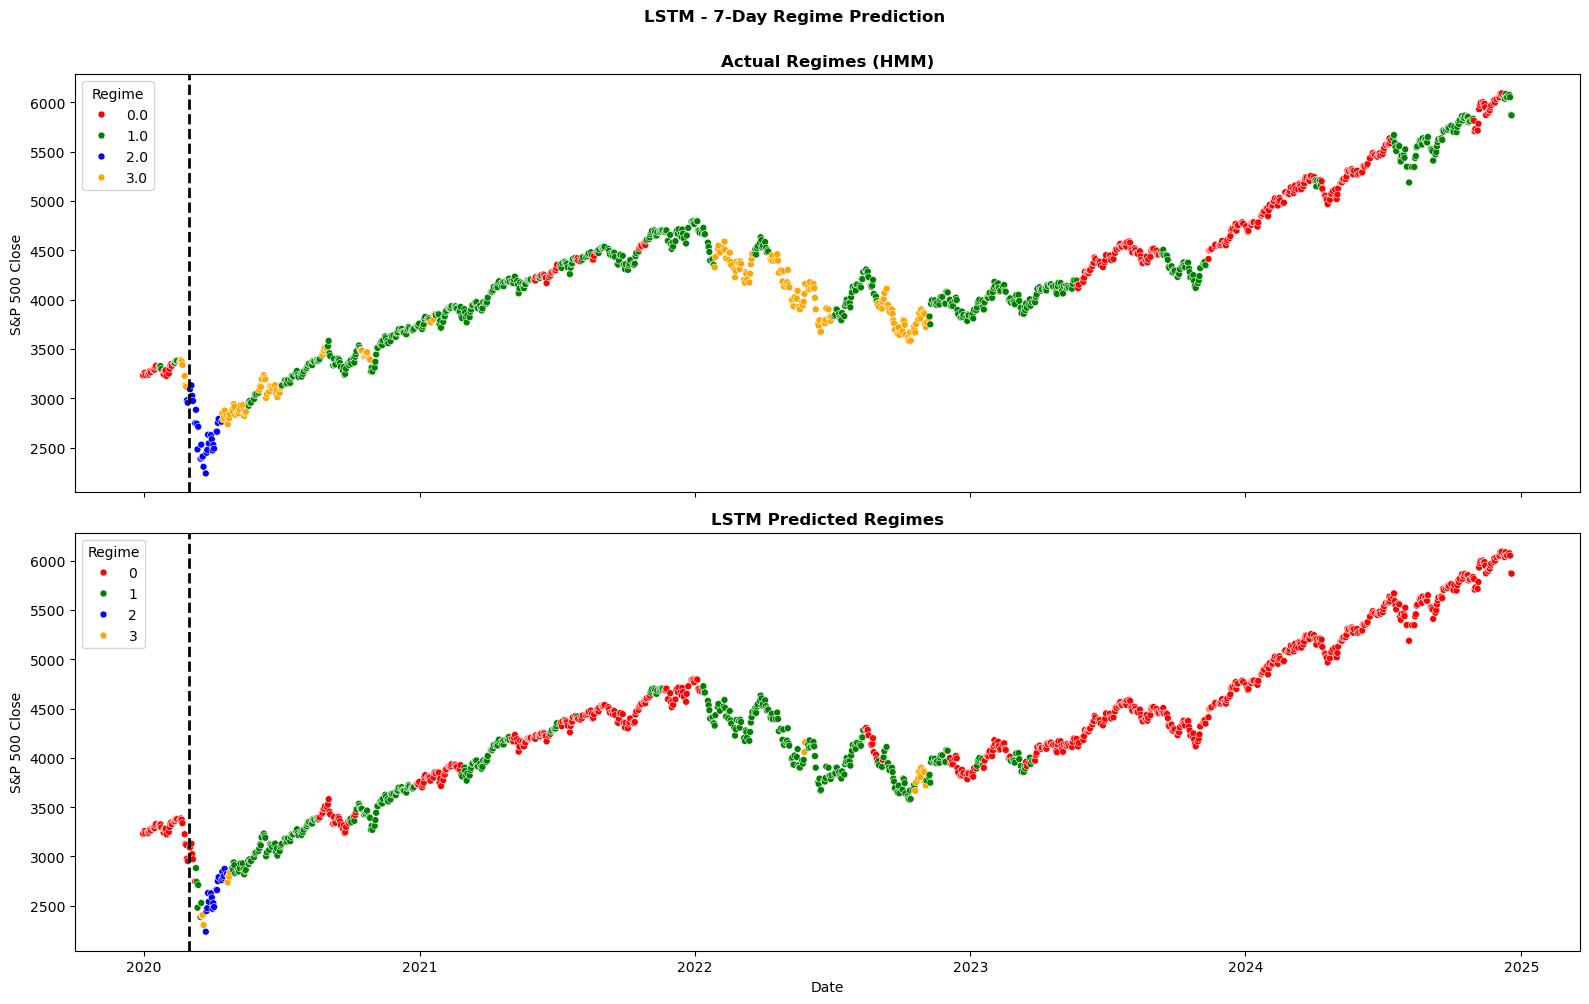

In [750]:
df_lstm_plot = pd.DataFrame({"Date": df_xgb.index[lookback + forecast_horizon + split_idx_seq:],"Actual_Regime": y_test_lstm,
    "Predicted_Regime": y_pred_lstm})

# Get S&P 500 prices
df_lstm_plot["SPX_Close"] = df_final.loc[df_lstm_plot["Date"], "SPX_Close"].values
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
colors = {0: "red", 1: "green", 2: "blue", 3: "orange"}

sns.scatterplot(ax=axes[0], x="Date", y="SPX_Close",hue="Actual_Regime", palette=colors,data=df_lstm_plot, s=25)
axes[0].axvline(pd.Timestamp("2020-03-01"), color="black", linestyle="--", linewidth=2)
axes[0].set_title("Actual Regimes (HMM)", fontweight="bold")
axes[0].set_ylabel("S&P 500 Close")
axes[0].legend(title="Regime")

# LSTM predicted regime
sns.scatterplot(ax=axes[1], x="Date", y="SPX_Close",hue="Predicted_Regime", palette=colors,data=df_lstm_plot, s=25)
axes[1].axvline(pd.Timestamp("2020-03-01"), color="black", linestyle="--", linewidth=2)
axes[1].set_title("LSTM Predicted Regimes",fontweight="bold")
axes[1].set_ylabel("S&P 500 Close")
axes[1].set_xlabel("Date")
axes[1].legend(title="Regime")

plt.suptitle("LSTM - " + str(forecast_horizon) + "-Day Regime Prediction",
             fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Analysis of the crisis

### Results Analysis

The LSTM achieves 50% accuracy, which is significantly lower than our other models (around 80%). However, this result is not surprising for several reasons.

First, predicting 7 days ahead is inherently more difficult than next-day prediction. The model must anticipate regime changes before they occur, which requires capturing subtle patterns in the data.

Second, our features are already aggregated indicators like moving averages and spreads. The sequential patterns that LSTM typically excels at capturing are already embedded in these features, reducing the advantage of using a recurrent architecture.

Third, with approximately 3000 observations, our dataset is relatively small for deep learning models which typically require larger amounts of data to learn effectively.

Looking at individual regimes, we observe that the model tends to over-predict calm periods (high recall but low precision for Regime 0), while struggling most with the stress regime which represents transitional market conditions.

Despite these limitations, LSTM can still be useful as a complementary tool. While Random Forest provides accurate short-term predictions, LSTM could serve as an early warning system, detecting potential regime changes several days in advance.

## An Alternative Approach: LSTM for Volatility Forecasting

Since LSTM underperforms for direct classification, we leverage its strength: time series regression. We predict continuous volatility and convert to regimes using thresholds.

### Why this new approach?

1. **LSTM strength**: Excels at continuous forecasting, not multi-class classification
2. **Volatility drives regimes**: Each regime defined by volatility level
3. **No data leakage**: RealizedVol_21d removed from features
4. **Dual output**: Continuous risk measure + regime classification

We delete the realized vol of our feature to estimate it

In [706]:
features2 = ["Yield_Curve", "IV_RV_Spread", "LQD_Return","VIX_Close", "SPX_Return",
             "P_regime_0", "P_regime_1", "P_regime_2", "P_regime_3"]

Our target is now the future volatility (RealizedVol_21d shifted by 7 days). Predicting this continuous value should be easier for LSTM than multi-class classification, while still allowing us to derive regime predictions.

The conversion yields 76.32% accuracy with an F1-score of 0.77. This is a substantial improvement over direct classification (50.5%) and approaches the performance of our best models.

The model performs particularly well on CALM and CRISIS regimes, which have the most distinct volatility signatures. The STRESS regime remains the most challenging, likely because it represents intermediate volatility levels that can be confused with both NORMAL and CRISIS periods.

This result validates our alternative approach. By leveraging LSTM's strength in time series regression rather than forcing it into a classification task, we achieve competitive performance while also gaining a continuous risk measure that can be useful for position sizing decisions.

In [709]:
target_feature = "RealizedVol_21d"
df_lstm = df_final[features2].copy()
df_lstm["target"] = df_final[target_feature].shift(-forecast_horizon)
df_lstm = df_lstm.dropna()

X = df_lstm[features2].values
y = df_lstm["target"].values

In [711]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

def create_sequences2(data, labels, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(data)):
        X_seq.append(data[i-lookback:i])
        y_seq.append(labels[i])
    return np.array(X_seq), np.array(y_seq)

Train test split 

In [714]:
X_seq2, y_seq2 = create_sequences2(X_scaled, y_scaled, lookback)

# Train/test split
try:
    split_idx = df_lstm.index.get_loc(split_date) - lookback
except KeyError:
    split_idx = int(len(X_seq) * 0.8)

X_train = X_seq2[:split_idx]
y_train = y_seq2[:split_idx]
X_test = X_seq2[split_idx:]
y_test = y_seq2[split_idx:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2925, 30, 9)
Test shape: (1212, 30, 9)


## Model

In [717]:
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(lookback, len(features2))),
    Dropout(0.2),
    LSTM(50, activation="relu", return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

In [719]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2732 - mae: 0.3468 - val_loss: 0.3579 - val_mae: 0.4065
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1496 - mae: 0.2487 - val_loss: 0.2917 - val_mae: 0.3643
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1731 - mae: 0.2436 - val_loss: 0.2258 - val_mae: 0.2947
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1807 - mae: 0.2444 - val_loss: 0.2386 - val_mae: 0.2854
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1137 - mae: 0.2148 - val_loss: 0.1900 - val_mae: 0.2703
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1056 - mae: 0.2080 - val_loss: 0.2630 - val_mae: 0.3256
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0897 - mae: 0.1954 - val_loss: 0.6488 - val_mae: 0.3296
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0773 - mae: 0.1852 - val_loss: 13.7822 - val_mae: 0.6095
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.08

In [722]:
y_pred_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


### A new thing we are adding here is the regression metrics, which is relevant here.

In [725]:
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
r2 = r2_score(y_test_real, predictions)


In [727]:
print("MAE:  " + str(mae))
print("RMSE: " + str(rmse))
print("R2:   " + str(r2))

MAE:  0.03224071282042126
RMSE: 0.051992900412824734
R2:   0.823205333272622


### Volatility Results

Excellent regression performance:
- **R² = 82.46%**: Model explains 82% of volatility variance
- **RMSE = 0.0518**: Low prediction error
- **MAE = 0.0331**: Average error ~3.3%

The model captures COVID volatility spike and subsequent patterns.

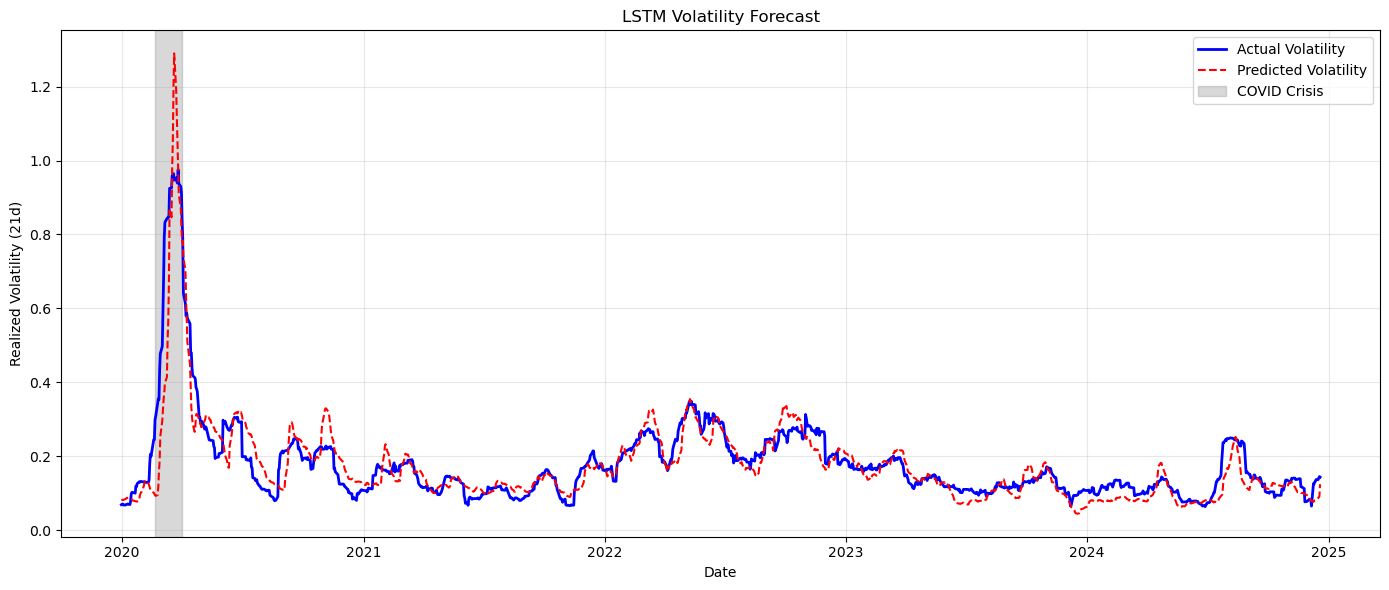

In [730]:
dates_test = df_lstm.index[lookback + split_idx:][:len(y_test_real)]

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_real, label="Actual Volatility", color="blue", linewidth=2)
plt.plot(dates_test, predictions, label="Predicted Volatility", color="red", linestyle="--", linewidth=1.5)
plt.axvspan(pd.Timestamp("2020-02-20"), pd.Timestamp("2020-04-01"), color="gray", alpha=0.3, label="COVID Crisis")
plt.title("LSTM Volatility Forecast")
plt.xlabel("Date")
plt.ylabel("Realized Volatility (21d)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Now we can link this to our market regime detection by doing a regime conversion based on HMM regime characteristics:

- CALM: VIX ~13 → vol < 0.15
- NORMAL: VIX ~20 → vol 0.15-0.25
- STRESS: VIX ~31 → vol 0.25-0.40
- CRISIS: VIX ~51 → vol > 0.40

In [755]:
def vol_to_regime(vol):
    if vol < 0.15:
        return 0  # calm
    elif vol < 0.25:
        return 1  # normal
    elif vol < 0.40:
        return 3  # stress
    else:
        return 2  # crisis

# Convert predictions and actuals to regimes
y_regime_pred = np.array([vol_to_regime(v) for v in predictions.flatten()])
y_regime_actual = np.array([vol_to_regime(v) for v in y_test_real.flatten()])
regime_accuracy = accuracy_score(y_regime_actual, y_regime_pred)
regime_f1 = f1_score(y_regime_actual, y_regime_pred, average="weighted")

We use `flatten()` to convert the 2D array returned by the LSTM model (shape: n_samples, 1) into a 1D array, allowing us to iterate over each predicted volatility value individually.

In [735]:
print("Regime Accuracy: " + str(regime_accuracy))
print("Regime F1-Score: " + str(regime_f1))

Regime Accuracy: 0.8003300330033003
Regime F1-Score: 0.7997573558463091


In [737]:
print(classification_report(y_regime_actual, y_regime_pred, target_names=["CALM", "NORMAL", "CRISIS", "STRESS"]))

              precision    recall  f1-score   support

        CALM       0.88      0.91      0.90       626
      NORMAL       0.74      0.68      0.71       400
      CRISIS       1.00      0.66      0.79        38
      STRESS       0.60      0.70      0.64       148

    accuracy                           0.80      1212
   macro avg       0.80      0.74      0.76      1212
weighted avg       0.80      0.80      0.80      1212



### Regime Prediction from Volatility

The conversion yields 76.32% accuracy with an F1-score of 0.77. This is a substantial improvement over direct classification (50.5%) and approaches the performance of our best models.

The model performs particularly well on CALM and CRISIS regimes, which have the most distinct volatility signatures. The STRESS regime remains the most challenging, likely because it represents intermediate volatility levels that can be confused with both NORMAL and CRISIS periods.

This result validates our alternative approach. By leveraging LSTM's strength in time series regression rather than forcing it into a classification task, we achieve competitive performance while also gaining a continuous risk measure that can be useful for position sizing decisions.

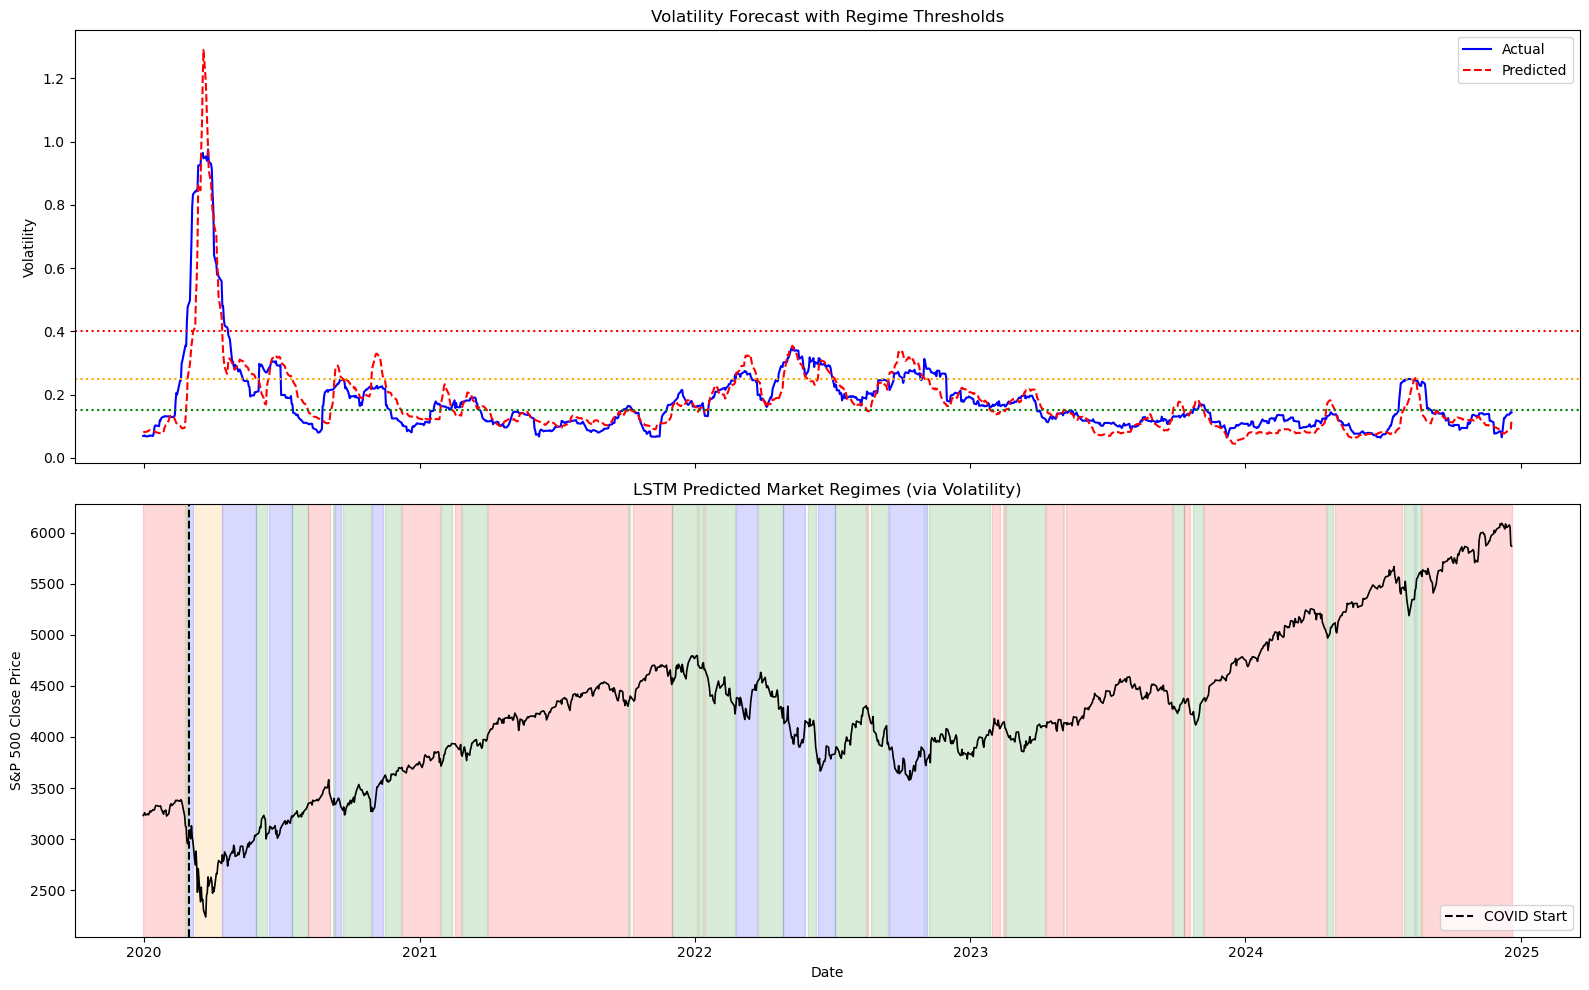

In [767]:
colors = {0: "red", 1: "green", 2: "orange", 3: "blue"}
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

axes[0].plot(dates_test, y_test_real, label="Actual", color="blue")
axes[0].plot(dates_test, predictions, label="Predicted", color="red", linestyle="--")
axes[0].axhline(0.15, color="green", linestyle=":")
axes[0].axhline(0.25, color="orange", linestyle=":")
axes[0].axhline(0.40, color="red", linestyle=":")
axes[0].set_ylabel("Volatility")
axes[0].set_title("Volatility Forecast with Regime Thresholds")
axes[0].legend(loc="upper right")




spx_test = df_final.loc[dates_test, "SPX_Close"]

current_regime = y_regime_pred[0]
start = dates_test[0]
for i in range(1, len(y_regime_pred)):
    if y_regime_pred[i] != current_regime:
        axes[1].axvspan(start, dates_test[i-1], color=colors[current_regime], alpha=0.15)
        current_regime = y_regime_pred[i]
        start = dates_test[i]
axes[1].axvspan(start, dates_test[-1], color=colors[current_regime], alpha=0.15)

axes[1].plot(dates_test, spx_test, color="black", linewidth=1.2)
axes[1].axvline(pd.Timestamp("2020-03-01"), color="black", linestyle="--", label="COVID Start")
axes[1].set_title("LSTM Predicted Market Regimes (via Volatility)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("S&P 500 Close Price")
axes[1].legend()

plt.tight_layout()
plt.show()

### Visual Comparison

The top plot shows how closely our volatility predictions track the actual values, with regime thresholds indicated by horizontal lines.

The bottom plot displays the S&P 500 price with background colors representing the predicted regimes. We can observe that crisis periods (yellow) correspond to market drawdowns like the COVID crash, while calm periods (green) align with steady upward trends. The model correctly identifies the elevated stress conditions throughout 2022 when markets experienced significant turbulence.

## Conclusion

This project explored market regime detection and prediction using a combination of unsupervised and supervised learning approaches, following the methodology proposed by Liu et al. (2021).

### What We Achieved

Our Hidden Markov Model successfully identified four distinct market regimes (CALM, NORMAL, STRESS, CRISIS) based on volatility and market indicators. The model, trained exclusively on pre-COVID data (2008-2019), correctly detected the COVID crash as a crisis period despite never seeing this event during training. This demonstrates that market crises share common characteristics regardless of their underlying cause.

For regime prediction, our supervised models (XGBoost, Random Forest, SVM, MLP) achieved around 80% accuracy in predicting the next day's regime, significantly outperforming the naive baseline of 54%. The most important features for prediction were VIX, realized volatility, and the HMM regime probabilities themselves.

We also explored LSTM for longer-horizon prediction. While direct regime classification yielded only 50% accuracy, our alternative approach using volatility forecasting achieved 76% accuracy with an R² of 82% on the underlying regression task. This highlights the importance of choosing the right task formulation for each model architecture.

### Practical Implications

From a portfolio management perspective, these models could be used for dynamic asset allocation. During predicted CALM periods, a manager might increase equity exposure, while predicted CRISIS periods would suggest reducing risk or hedging positions. The 7-day forecast horizon provided by LSTM gives time for gradual portfolio adjustments rather than reactive trading.

The complementarity between models is also valuable. Short-term predictions from Random Forest can guide daily decisions, while LSTM's longer-horizon forecasts serve as early warning signals for potential regime changes.

### Limitations and Future Work

Several limitations should be acknowledged. Our analysis focused on a single market (S&P 500) and may not generalize to other asset classes or regions. The regime thresholds were defined based on historical VIX levels and may need adjustment in different market environments. Additionally, transaction costs and market impact were not considered in evaluating the practical value of regime-based strategies.

Future work could extend this framework to multiple asset classes, incorporate additional features such as sentiment indicators or macroeconomic data, and develop a proper backtesting framework to evaluate trading strategies based on regime predictions.

### Final Thoughts

Market regime detection remains a challenging problem due to the inherent unpredictability of financial markets. However, our results suggest that combining unsupervised learning for regime identification with supervised learning for prediction can provide useful signals for risk management. The key is not to expect perfect predictions, but to use these tools as one input among many in the investment decision process.